<a href="https://colab.research.google.com/github/leonyangucl/2023fyp/blob/main/PD_inpainting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
import random
import nibabel as nib

## Read the data

In [3]:
import nibabel as nib
import matplotlib.pyplot as plt

#pCASL
img_pCASL = nib.load('/content/drive/MyDrive/Colab Notebooks/thesis/ANONYMISED/21174/ASL/pCASL_data.nii.gz')
#PD_cal
img_PD_cal = nib.load('/content/drive/MyDrive/Colab Notebooks/thesis/ANONYMISED/21174/ASL/PD_cal.nii.gz')
#PWI_corr
img_PWI_corr = nib.load('/content/drive/MyDrive/Colab Notebooks/thesis/ANONYMISED/21174/ASL/PWI_corr.nii.gz')
#ROI_hd
img_ROI_hd = nib.load('/content/drive/MyDrive/Colab Notebooks/thesis/ANONYMISED/21174/T1/ROI_hd.nii.gz')
#T1_brain_hd
img_T1_brain_hd = nib.load('/content/drive/MyDrive/Colab Notebooks/thesis/ANONYMISED/21174/T1/T1_brain_hd.nii.gz')


In [4]:
data_pCASL = img_pCASL.get_fdata()
data_PD_cal = img_PD_cal.get_fdata()
data_PWI_corr = img_PWI_corr.get_fdata()
data_ROI_hd = img_ROI_hd.get_fdata()
data_T1_brain_hd = img_T1_brain_hd.get_fdata()


print(data_pCASL.shape)
print(data_PD_cal.shape)
print(data_PWI_corr.shape)
print(data_ROI_hd.shape)
print(data_T1_brain_hd.shape)

(80, 80, 20, 70)
(80, 80, 20, 3)
(80, 80, 20)
(192, 256, 192)
(192, 256, 192)


In [5]:
## old method
# import os
# import nibabel as nib
# import numpy as np

# dir_path = '/content/drive/MyDrive/Colab Notebooks/thesis/ANONYMISED'

# all_data = []

# for folder_name in os.listdir(dir_path):
#     file_path = os.path.join(dir_path, folder_name, 'ASL','PD_cal.nii.gz')
#     if os.path.exists(file_path):
#         img = nib.load(file_path)
#         data = img.get_fdata()
#         for i in range(data.shape[-1]):
#             for j in range(data.shape[-2]):
#                 slice_data = data[..., j, i]
#                 # normalization for each slice
#                 min_val = np.min(slice_data)
#                 max_val = np.max(slice_data)
#                 norm_data = (slice_data - min_val) / (max_val - min_val) if max_val > min_val else slice_data
#                 all_data.append(norm_data)

# dataset = np.stack(all_data)


In [6]:
import os
import nibabel as nib
import numpy as np

dir_path = '/content/drive/MyDrive/Colab Notebooks/thesis/ANONYMISED'

all_data = []

for folder_name in os.listdir(dir_path):
    file_path = os.path.join(dir_path, folder_name, 'ASL','PD_cal.nii.gz')
    if os.path.exists(file_path):
        img = nib.load(file_path)
        data = img.get_fdata()
        for i in range(data.shape[-1]):
            for j in range(8, 18):
                slice_data = data[..., j, i]
                # normalization for each slice
                min_val = np.min(slice_data)
                max_val = np.max(slice_data)
                norm_data = (slice_data - min_val) / (max_val - min_val) if max_val > min_val else slice_data
                all_data.append(norm_data)

dataset = np.stack(all_data)

In [7]:
dataset.shape

(1710, 80, 80)

## Optional: data augmentation

In [ ]:
from imgaug import augmenters as iaa

seq = iaa.Sequential([
    iaa.Affine(rotate=(-25, 25)),  # rotate
    iaa.Fliplr(0.5),  # flip left right
    iaa.Flipud(0.5),  # flip upsidedown
], random_order=True)

dataset_augmented = []

for image in dataset:
    for _ in range(5):
        image_augmented = seq(image=image)
        dataset_augmented.append(image_augmented)

dataset = np.stack(dataset_augmented)


In [ ]:
dataset.shape

## Image masking

In [8]:
from skimage.draw import random_shapes
import numpy as np


image_shape = (80, 80)
max_shapes = 1
min_size = 25
max_size = 40
shape = 'circle'


new_dataset = []
labels = []
masks = []

for image in dataset:
    for _ in range(5):
        mask, _ = random_shapes(image_shape, max_shapes=max_shapes,
                                min_size=min_size, max_size=max_size,
                                channel_axis=None, shape=shape)

        mask = (mask == 255).astype(float)
        image_masked = np.where(mask == 0, 0, image)


        new_dataset.append(image_masked)
        labels.append(image)
        masks.append(mask)


new_dataset = np.stack(new_dataset)
labels = np.stack(labels)
masks = np.stack(masks)

print('data shape', new_dataset.shape)
print('label shape', labels.shape)
print('mask shape', masks.shape)


data shape (8550, 80, 80)
label shape (8550, 80, 80)
mask shape (8550, 80, 80)


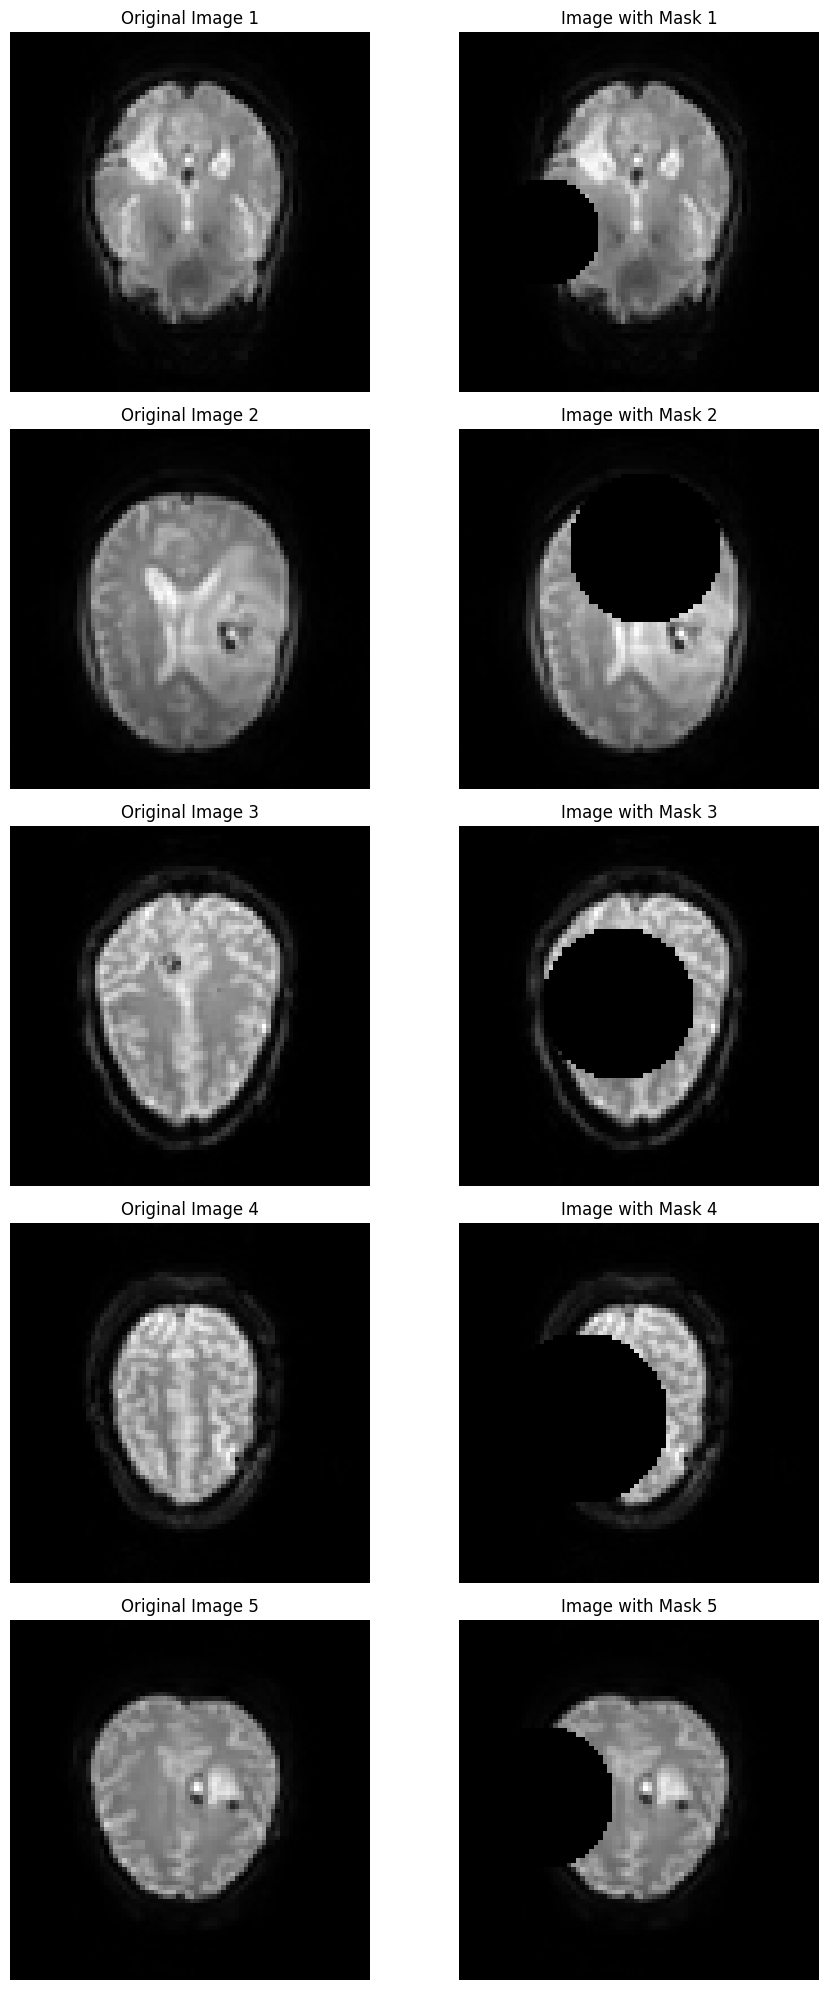

In [9]:
import matplotlib.pyplot as plt
import random

indices = random.sample(range(new_dataset.shape[0]), 5)

plt.figure(figsize=(10, 20))

for i, index in enumerate(indices):
    # original image
    plt.subplot(5, 2, i*2+1)
    plt.imshow(labels[index].T, cmap='gray')
    plt.title(f'Original Image {i+1}')
    plt.axis('off')

    # masked image
    plt.subplot(5, 2, i*2+2)
    plt.imshow(new_dataset[index].T, cmap='gray')
    plt.title(f'Image with Mask {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


## Useless code

In [ ]:
# from keras.models import Model
# from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

# def create_model():
#     inputs = Input((80, 80, 1))

#     # encoder
#     conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

#     conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

#     conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
#     pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

#     # decoder
#     conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
#     up1 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv3], axis=-1)

#     conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(up1)
#     up2 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv2], axis=-1)

#     conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(up2)
#     up3 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv1], axis=-1)

#     # output layer
#     conv7 = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up3)

#     model = Model(inputs=[inputs], outputs=[conv7])

#     return model

# model = create_model()
# model.summary()


In [ ]:
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, \
#     ReLU, BatchNormalization, UpSampling2D, concatenate
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.models import Model

# input_shape = (80, 80, 1)
# num_classes = 20


# def conv(x, f, s=1):
#     x = Conv2D(filters=f, kernel_size=3, strides=s, padding='same')(x)
#     x = BatchNormalization()(x)
#     x = ReLU()(x)
#     return x


# def upsample(x):
#     x = UpSampling2D(size=(2, 2), interpolation='bilinear')(x)
#     x = BatchNormalization()(x)
#     x = ReLU()(x)
#     return x


# # 572*572
# input = Input(shape=input_shape)
# x = conv(input, f=64)
# p1 = conv(x, f=64)
# x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(p1)
# x = conv(x, f=128)
# p2 = conv(x, f=128)
# x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(p2)
# x = conv(x, f=256)
# p3 = conv(x, f=256)
# x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(p3)
# x = conv(x, f=512)
# p4 = conv(x, f=512)
# x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(p4)
# x = conv(x, f=1024)
# p5 = conv(x, f=1024)
# x = upsample(p5)
# x = concatenate([p4, x], axis=-1)
# x = conv(x, f=512)
# t4 = conv(x, f=512)
# x = upsample(t4)
# x = concatenate([p3, x], axis=-1)
# x = conv(x, f=256)
# t3 = conv(x, f=256)
# x = upsample(t3)
# x = concatenate([p2, x], axis=-1)
# x = conv(x, f=128)
# t2 = conv(x, f=128)
# x = upsample(t2)
# x = concatenate([p1, x], axis=-1)
# x = conv(x, f=64)
# x = conv(x, f=64)
# #x = Conv2D(filters=num_classes, kernel_size=1, strides=1, padding='same', activation='softmax')(x)
# x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
# model = Model(input, x)

# model.summary()

In [ ]:
# from keras.models import Model
# from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

# def create_model():
#     inputs = Input((80, 80, 1))

#     # encoder
#     conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
#     conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

#     conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
#     conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

#     conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
#     conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
#     pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

#     conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
#     conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
#     pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

#     # middle
#     conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
#     conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

#     # decoder
#     up1 = UpSampling2D(size=(2, 2))(conv5)
#     up1 = concatenate([conv4, up1], axis=-1)
#     conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up1)
#     conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

#     up2 = UpSampling2D(size=(2, 2))(conv6)
#     up2 = concatenate([conv3, up2], axis=-1)
#     conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up2)
#     conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

#     up3 = UpSampling2D(size=(2, 2))(conv7)
#     up3 = concatenate([conv2, up3], axis=-1)
#     conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up3)
#     conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

#     up4 = UpSampling2D(size=(2, 2))(conv8)
#     up4 = concatenate([conv1, up4], axis=-1)
#     conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up4)
#     conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

#     # output layer
#     conv10 = Conv2D(1, (3, 3), activation='sigmoid',padding='same')(conv9)

#     model = Model(inputs=[inputs], outputs=[conv10])

#     return model

# model = create_model()
# model.summary()


In [ ]:
# from keras.models import Model
# from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization,Activation

# def create_model():
#     inputs = Input((80, 80, 1))

#     # encoder
#     conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
#     conv1 = BatchNormalization()(conv1)
#     conv1 = Activation('relu')(conv1)
#     conv1 = Conv2D(64, (3, 3), padding='same')(conv1)
#     conv1 = BatchNormalization()(conv1)
#     conv1 = Activation('relu')(conv1)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

#     conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
#     conv2 = BatchNormalization()(conv2)
#     conv2 = Activation('relu')(conv2)
#     conv2 = Conv2D(128, (3, 3), padding='same')(conv2)
#     conv2 = BatchNormalization()(conv2)
#     conv2 = Activation('relu')(conv2)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

#     conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
#     conv3 = BatchNormalization()(conv3)
#     conv3 = Activation('relu')(conv3)
#     conv3 = Conv2D(256, (3, 3), padding='same')(conv3)
#     conv3 = BatchNormalization()(conv3)
#     conv3 = Activation('relu')(conv3)
#     pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

#     conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
#     conv4 = BatchNormalization()(conv4)
#     conv4 = Activation('relu')(conv4)
#     conv4 = Conv2D(512, (3, 3), padding='same')(conv4)
#     conv4 = BatchNormalization()(conv4)
#     conv4 = Activation('relu')(conv4)
#     pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

#     # middle
#     conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
#     conv5 = BatchNormalization()(conv5)
#     conv5 = Activation('relu')(conv5)
#     conv5 = Conv2D(1024, (3, 3), padding='same')(conv5)
#     conv5 = BatchNormalization()(conv5)
#     conv5 = Activation('relu')(conv5)

#     # decoder
#     up1 = UpSampling2D(size=(2, 2))(conv5)
#     up1 = concatenate([conv4, up1], axis=-1)
#     conv6 = Conv2D(512, (3, 3), padding='same')(up1)
#     conv6 = BatchNormalization()(conv6)
#     conv6 = Activation('relu')(conv6)
#     conv6 = Conv2D(512, (3, 3), padding='same')(conv6)
#     conv6 = BatchNormalization()(conv6)
#     conv6 = Activation('relu')(conv6)

#     up2 = UpSampling2D(size=(2, 2))(conv6)
#     up2 = concatenate([conv3, up2], axis=-1)
#     conv7 = Conv2D(256, (3, 3), padding='same')(up2)
#     conv7 = BatchNormalization()(conv7)
#     conv7 = Activation('relu')(conv7)
#     conv7 = Conv2D(256, (3, 3), padding='same')(conv7)
#     conv7 = BatchNormalization()(conv7)
#     conv7 = Activation('relu')(conv7)

#     up3 = UpSampling2D(size=(2, 2))(conv7)
#     up3 = concatenate([conv2, up3], axis=-1)
#     conv8 = Conv2D(128, (3, 3), padding='same')(up3)
#     conv8 = BatchNormalization()(conv8)
#     conv8 = Activation('relu')(conv8)
#     conv8 = Conv2D(128, (3, 3), padding='same')(conv8)
#     conv8 = BatchNormalization()(conv8)
#     conv8 = Activation('relu')(conv8)

#     up4 = UpSampling2D(size=(2, 2))(conv8)
#     up4 = concatenate([conv1, up4], axis=-1)
#     conv9 = Conv2D(64, (3, 3), padding='same')(up4)
#     conv9 = BatchNormalization()(conv9)
#     conv9 = Activation('relu')(conv9)
#     conv9 = Conv2D(64, (3, 3), padding='same')(conv9)
#     conv9 = BatchNormalization()(conv9)
#     conv9 = Activation('relu')(conv9)

#     # output layer
#     conv10 = Conv2D(1, (3, 3), activation='sigmoid',padding='same')(conv9)

#     model = Model(inputs=[inputs], outputs=[conv10])

#     return model

# model = create_model()
# model.summary()


## U-Net

In [10]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization,Activation

from tensorflow.keras.layers import Layer

class RestorationLayer(Layer):
    def __init__(self, **kwargs):
        super(RestorationLayer, self).__init__(**kwargs)

    def call(self, inputs):
        model_output, original_image, mask = inputs

        output_unmasked = model_output * (1 - mask)
        output_masked = original_image * mask
        final_output = output_unmasked + output_masked

        return final_output



def create_model():
    inputs = Input((80, 80, 1))
    original_image = Input((80, 80, 1))
    mask = Input((80, 80, 1))


    # encoder
    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # middle
    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)

    # decoder
    up1 = UpSampling2D(size=(2, 2))(conv5)
    up1 = concatenate([conv4, up1], axis=-1)
    conv6 = Conv2D(512, (3, 3), padding='same')(up1)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)

    up2 = UpSampling2D(size=(2, 2))(conv6)
    up2 = concatenate([conv3, up2], axis=-1)
    conv7 = Conv2D(256, (3, 3), padding='same')(up2)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)

    up3 = UpSampling2D(size=(2, 2))(conv7)
    up3 = concatenate([conv2, up3], axis=-1)
    conv8 = Conv2D(128, (3, 3), padding='same')(up3)
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation('relu')(conv8)

    up4 = UpSampling2D(size=(2, 2))(conv8)
    up4 = concatenate([conv1, up4], axis=-1)
    conv9 = Conv2D(64, (3, 3), padding='same')(up4)
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation('relu')(conv9)

    # output layer
    conv10 = Conv2D(1, (1, 1), activation='sigmoid',padding='same')(conv9)
    restored_image = RestorationLayer()([conv10, original_image, mask])

    model = Model(inputs=[inputs, original_image, mask], outputs=[restored_image])

    return model

model = create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 80, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 80, 80, 64)   640         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 80, 80, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 80, 80, 64)   0           ['batch_normalization[0][0]']

## Split the data

In [11]:
import numpy as np
from sklearn.model_selection import train_test_split

new_dataset1 = np.expand_dims(new_dataset, axis=-1)
labels1 = np.expand_dims(labels, axis=-1)
masks1 = np.expand_dims(masks, axis=-1)

X_train, X_test, y_train, y_test, masks_train, masks_test = train_test_split(new_dataset1, labels1, masks1, test_size=0.2, random_state=42)

## Method 1 (mse)

In [38]:
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import tensorflow as tf



model1 = create_model()
optimizer = Adam(learning_rate=0.001)
model1.compile(optimizer=optimizer, loss='mse')


early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model1.fit([X_train, y_train, masks_train], y_train, epochs=50, batch_size=128, validation_split=0.2, callbacks=[early_stop])


model1.evaluate([X_test, y_test,masks_test], y_test)


Epoch 1/50
43/43 [==============================] - 13s 265ms/step - loss: 0.0030 - val_loss: 0.0219
Epoch 2/50
43/43 [==============================] - 11s 246ms/step - loss: 0.0015 - val_loss: 0.0219
Epoch 3/50
43/43 [==============================] - 11s 249ms/step - loss: 0.0014 - val_loss: 0.0215
Epoch 4/50
43/43 [==============================] - 11s 248ms/step - loss: 0.0013 - val_loss: 0.0209
Epoch 5/50
43/43 [==============================] - 11s 248ms/step - loss: 0.0013 - val_loss: 0.0184
Epoch 6/50
43/43 [==============================] - 11s 249ms/step - loss: 0.0012 - val_loss: 0.0152
Epoch 7/50
43/43 [==============================] - 11s 248ms/step - loss: 0.0012 - val_loss: 0.0142
Epoch 8/50
43/43 [==============================] - 11s 249ms/step - loss: 0.0011 - val_loss: 0.0142
Epoch 9/50
43/43 [==============================] - 11s 246ms/step - loss: 0.0011 - val_loss: 0.0152
Epoch 10/50
43/43 [==============================] - 11s 246ms/step - loss: 0.0010 - val_lo

0.0008323083748109639

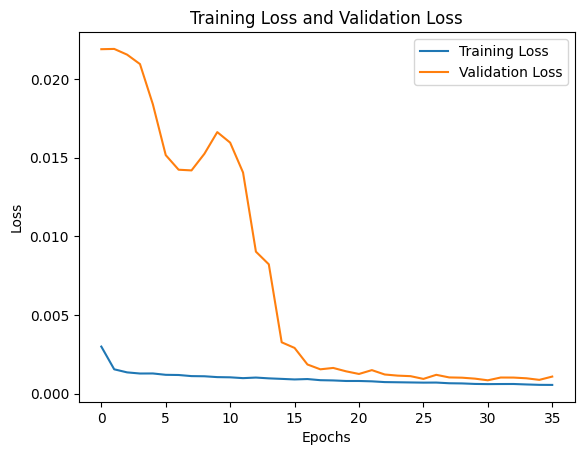

In [39]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.ylim([0,0.01])
plt.legend()
plt.show()


1/1 [==============================] - 0s 23ms/step


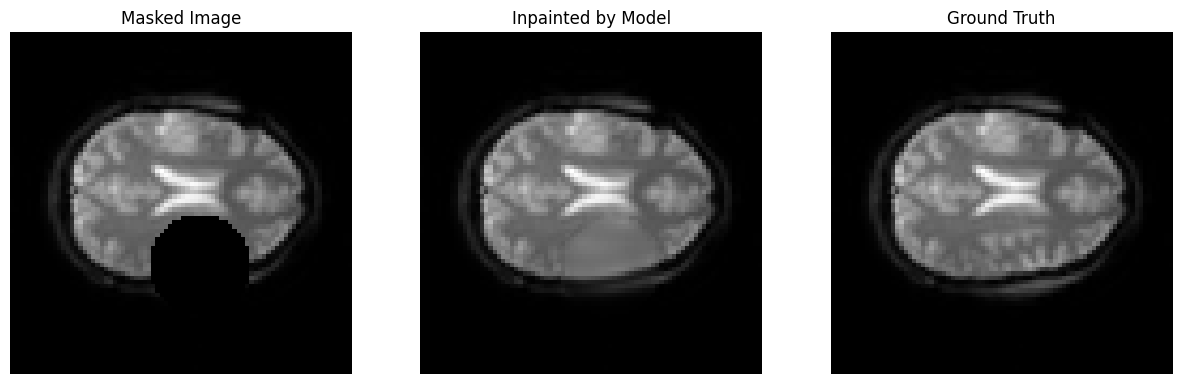

1/1 [==============================] - 0s 23ms/step


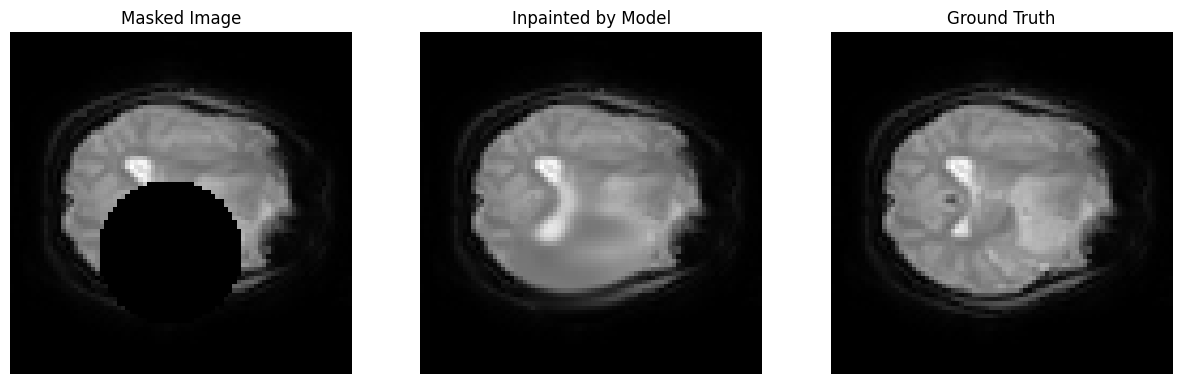

1/1 [==============================] - 0s 22ms/step


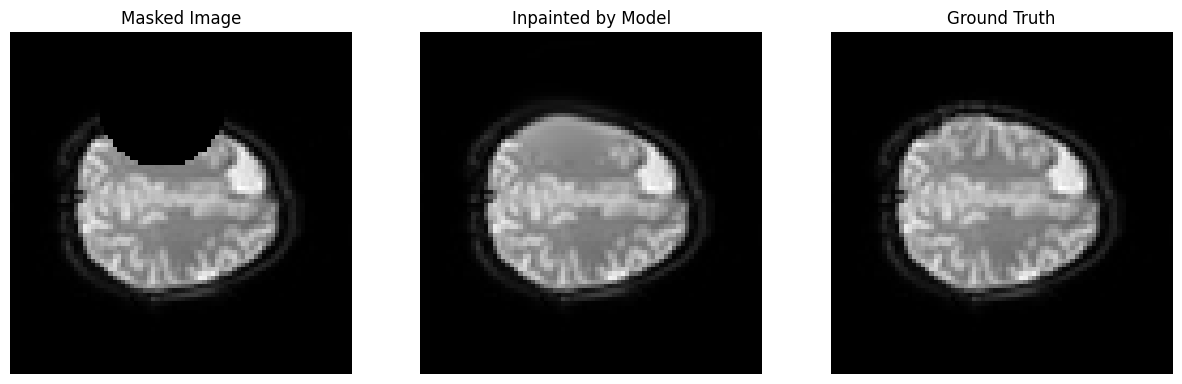

1/1 [==============================] - 0s 23ms/step


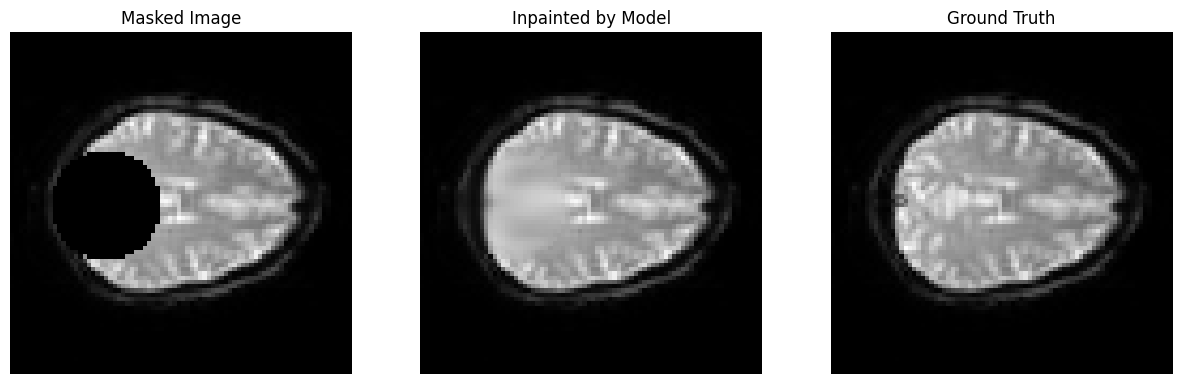

1/1 [==============================] - 0s 23ms/step


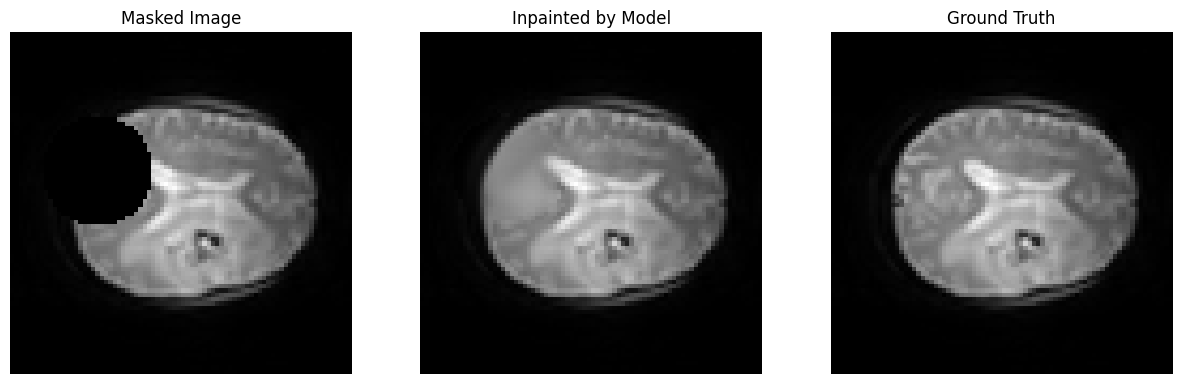

1/1 [==============================] - 0s 22ms/step


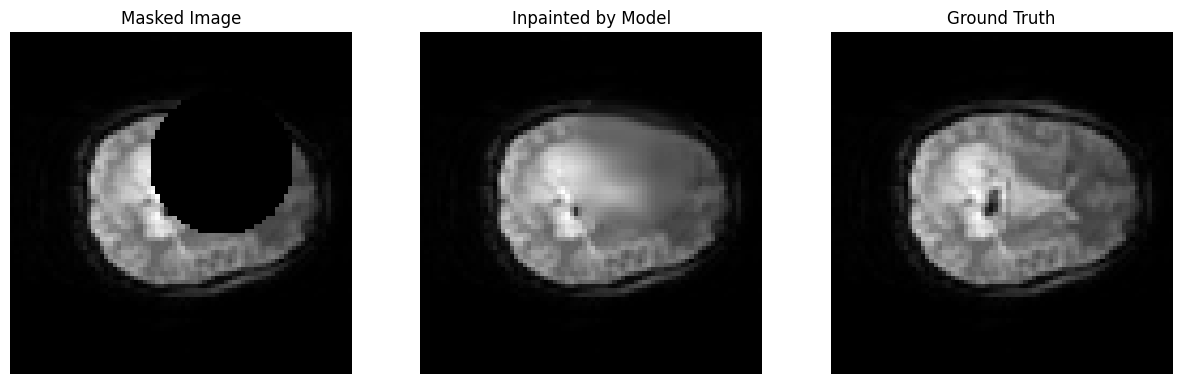

1/1 [==============================] - 0s 22ms/step


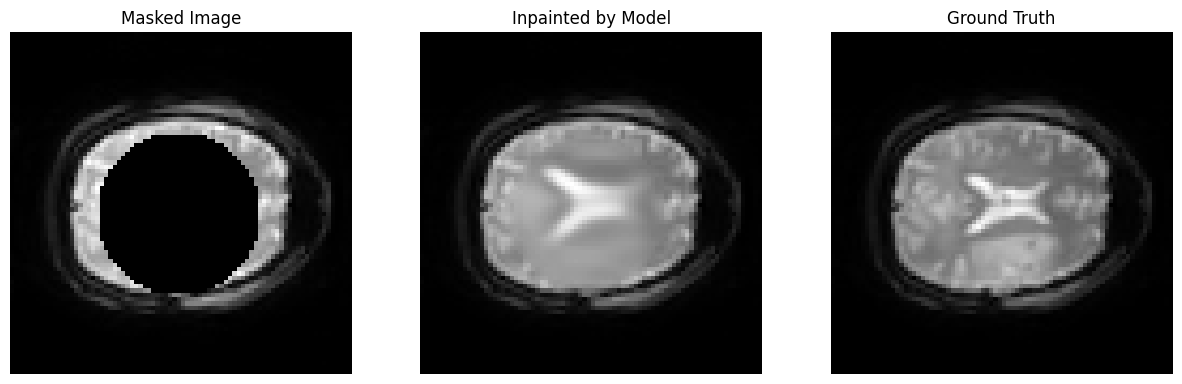

1/1 [==============================] - 0s 22ms/step


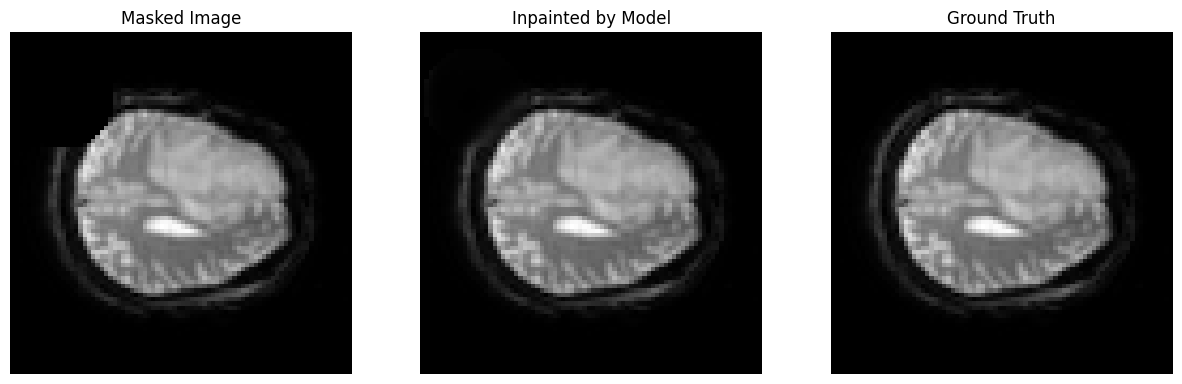

1/1 [==============================] - 0s 23ms/step


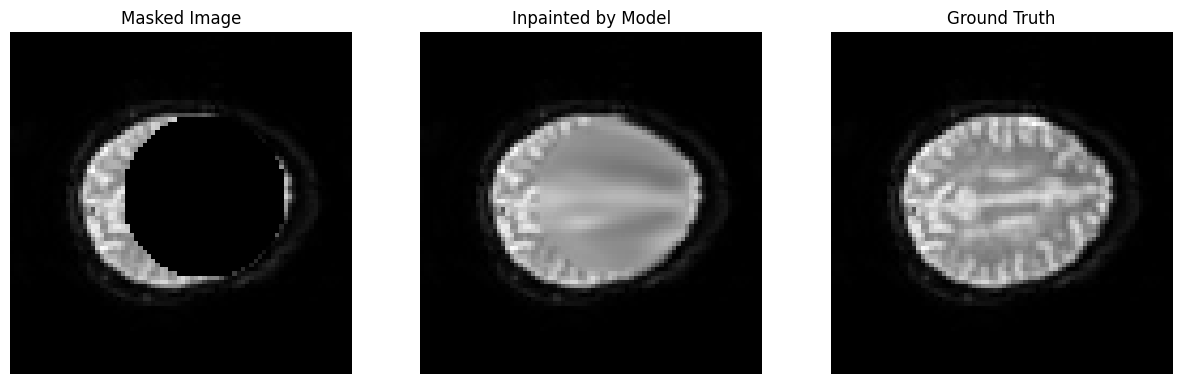

1/1 [==============================] - 0s 22ms/step


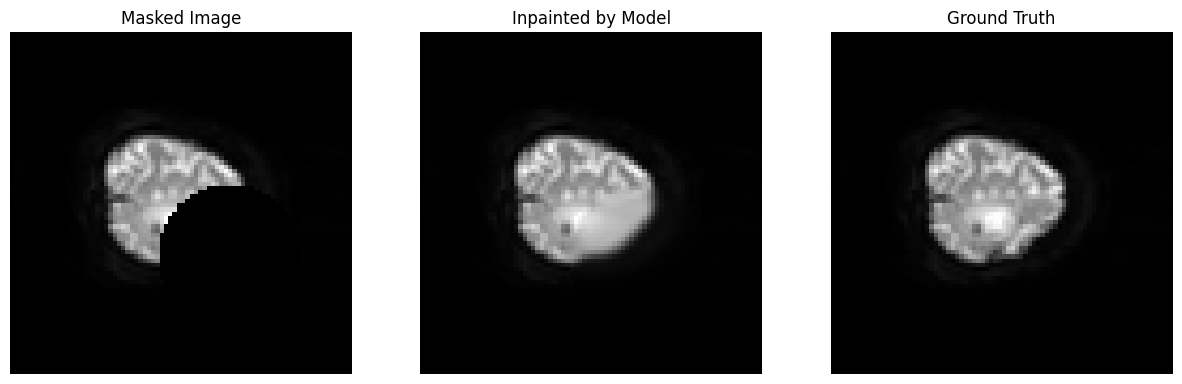

In [67]:
import matplotlib.pyplot as plt

np.random.seed(24)
num_images_to_show = 10

for i in range(num_images_to_show):
    img_index = np.random.randint(len(X_test))  # Use the length of your dataset

    masked_image = X_test[img_index]
    original_image = y_test[img_index]
    mask = masks_test[img_index]
    prediction = model1.predict([masked_image[np.newaxis, ...], original_image[np.newaxis, ...], mask[np.newaxis, ...]])[0]

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(masked_image.squeeze(), cmap='gray')
    plt.title('Masked Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(prediction.squeeze(), cmap='gray')
    plt.title('Inpainted by Model')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(original_image.squeeze(), cmap='gray')
    plt.title('Ground Truth')
    plt.axis('off')

    plt.show()

## Method 2 (ssim loss)

In [35]:
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import tensorflow as tf

def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))  #set 1.0 here because the range of images is [0,1]

model2 = create_model()
optimizer = Adam(learning_rate=0.005)
model2.compile(optimizer=optimizer, loss=ssim_loss)


early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
history = model2.fit([X_train, y_train, masks_train], y_train, epochs=50, batch_size=128, validation_split=0.2, callbacks=[early_stop])


model2.evaluate([X_test, y_test,masks_test], y_test)


Epoch 1/50
43/43 [==============================] - 14s 271ms/step - loss: 0.0953 - val_loss: 0.1794
Epoch 2/50
43/43 [==============================] - 11s 250ms/step - loss: 0.0732 - val_loss: 0.1742
Epoch 3/50
43/43 [==============================] - 11s 248ms/step - loss: 0.0683 - val_loss: 0.1772
Epoch 4/50
43/43 [==============================] - 11s 250ms/step - loss: 0.0662 - val_loss: 0.1383
Epoch 5/50
43/43 [==============================] - 11s 248ms/step - loss: 0.0652 - val_loss: 0.1531
Epoch 6/50
43/43 [==============================] - 11s 248ms/step - loss: 0.0612 - val_loss: 0.1482
Epoch 7/50
43/43 [==============================] - 11s 249ms/step - loss: 0.0592 - val_loss: 0.1482
Epoch 8/50
43/43 [==============================] - 11s 248ms/step - loss: 0.0583 - val_loss: 0.1443
Epoch 9/50
43/43 [==============================] - 11s 249ms/step - loss: 0.0572 - val_loss: 0.1446
Epoch 10/50
43/43 [==============================] - 11s 249ms/step - loss: 0.0545 - val_lo

0.046741876751184464

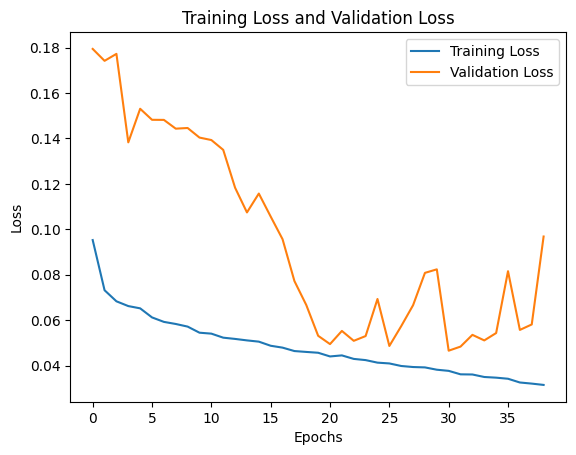

In [36]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.ylim([0,0.01])
plt.legend()
plt.show()


1/1 [==============================] - 0s 24ms/step


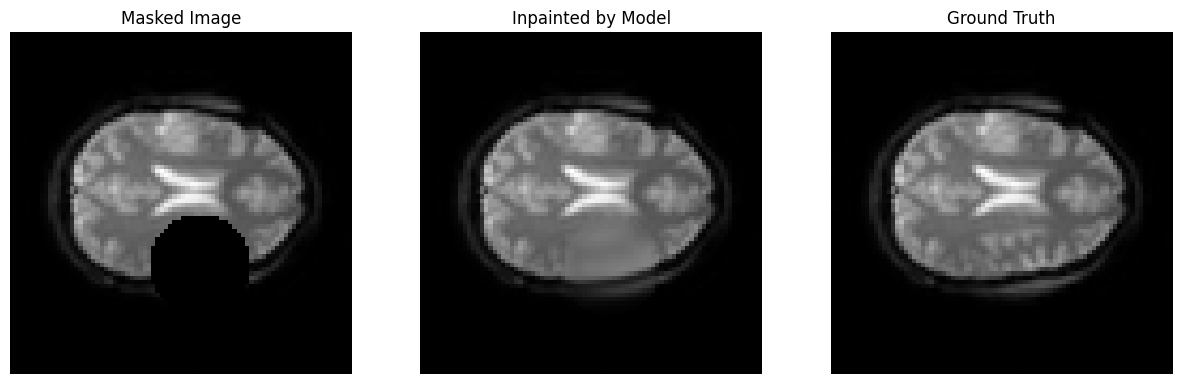

1/1 [==============================] - 0s 32ms/step


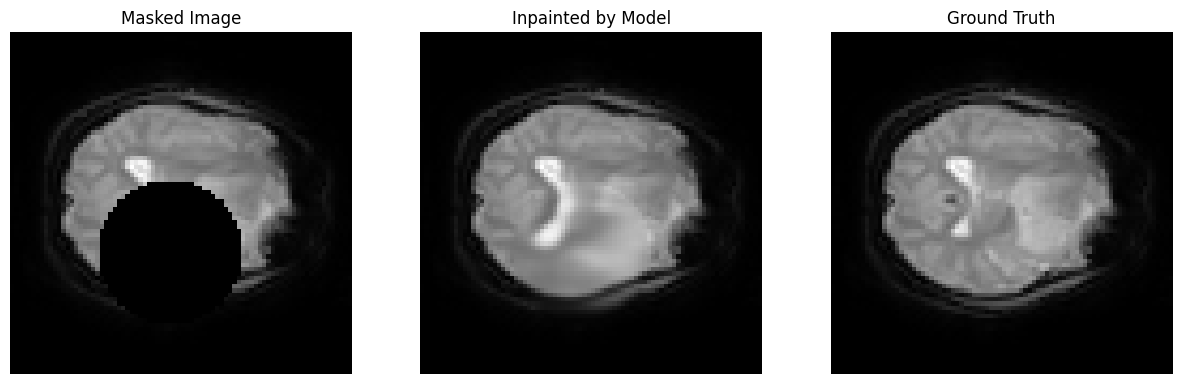

1/1 [==============================] - 0s 23ms/step


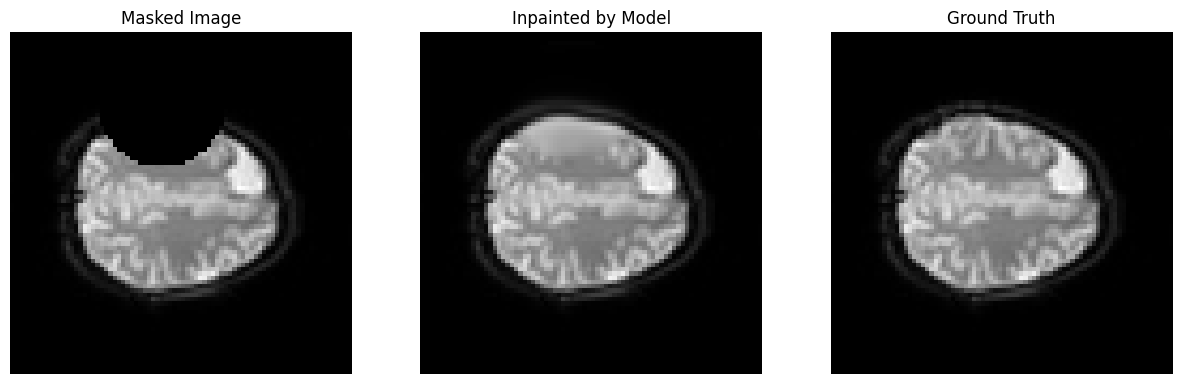

1/1 [==============================] - 0s 22ms/step


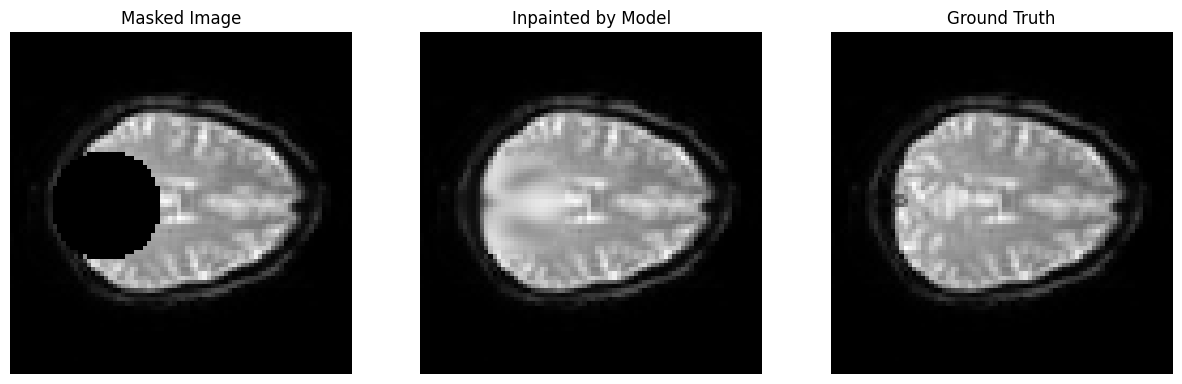

1/1 [==============================] - 0s 29ms/step


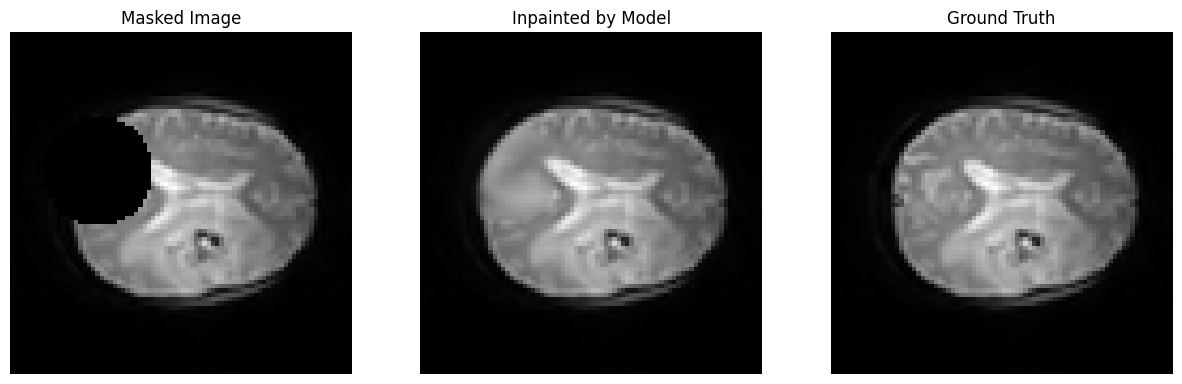

1/1 [==============================] - 0s 21ms/step


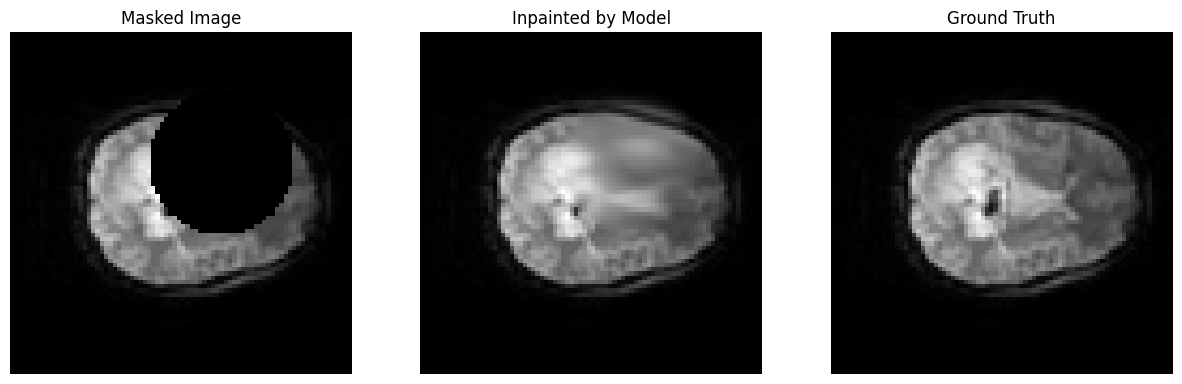

1/1 [==============================] - 0s 20ms/step


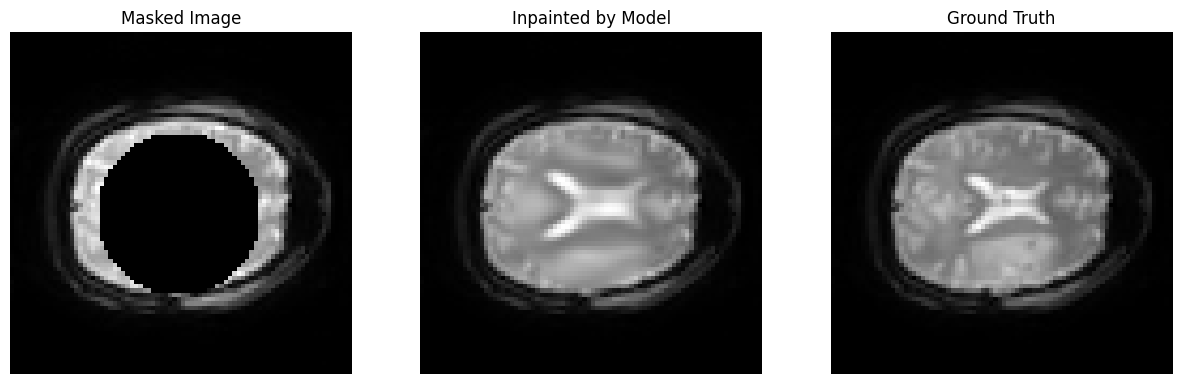

1/1 [==============================] - 0s 21ms/step


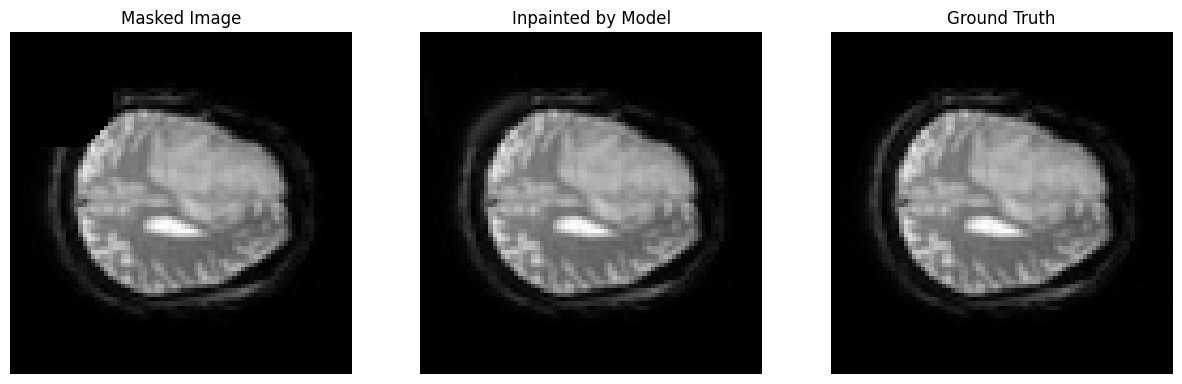

1/1 [==============================] - 0s 21ms/step


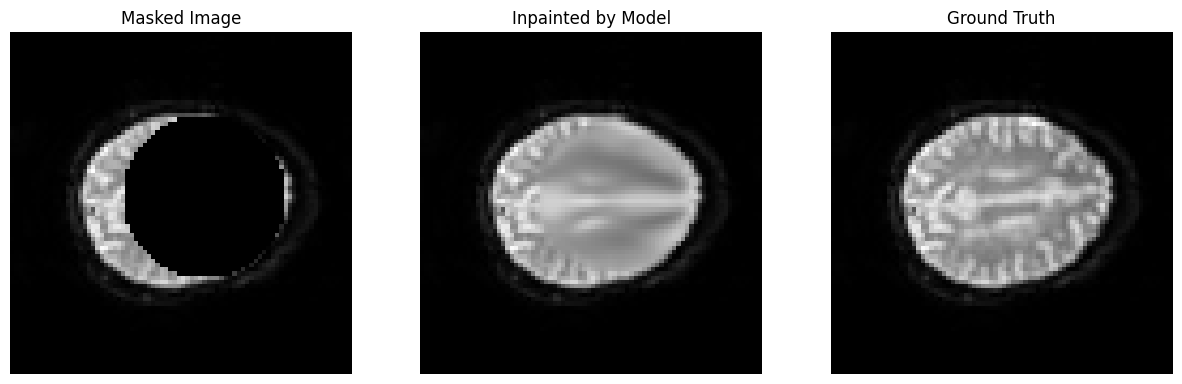

1/1 [==============================] - 0s 21ms/step


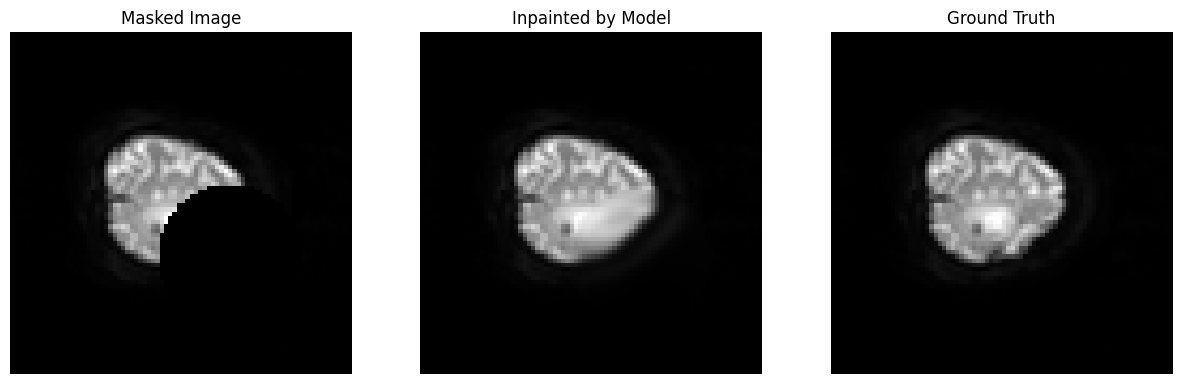

In [66]:
import matplotlib.pyplot as plt

np.random.seed(24)
num_images_to_show = 10

for i in range(num_images_to_show):
    img_index = np.random.randint(len(X_test))  # Use the length of your dataset

    masked_image = X_test[img_index]
    original_image = y_test[img_index]
    mask = masks_test[img_index]
    prediction = model2.predict([masked_image[np.newaxis, ...], original_image[np.newaxis, ...], mask[np.newaxis, ...]])[0]

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(masked_image.squeeze(), cmap='gray')
    plt.title('Masked Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(prediction.squeeze(), cmap='gray')
    plt.title('Inpainted by Model')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(original_image.squeeze(), cmap='gray')
    plt.title('Ground Truth')
    plt.axis('off')

    plt.show()

## Method 3 (perceptual loss)

In [41]:
# from keras.optimizers import Adam
# from keras.callbacks import EarlyStopping
# import tensorflow as tf
# from keras.applications.vgg16 import VGG16
# from keras.models import Model
# from keras import backend as K

# def ssim_loss(y_true, y_pred):
#     return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))  #set 1.0 here because the range of images is [0,1]

# def perceptual_loss(y_true, y_pred):
#     vgg = VGG16(include_top=False, weights='imagenet')
#     loss_model = Model(inputs=vgg.input, outputs=vgg.get_layer('block3_conv3').output)
#     loss_model.trainable = False
#     return K.mean(K.square(loss_model(y_true) - loss_model(y_pred)))


# model3 = create_model()
# optimizer = Adam(learning_rate=0.005)
# model3.compile(optimizer=optimizer, loss=perceptual_loss)


# early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# history = model3.fit([X_train, y_train, masks_train], y_train, epochs=50, batch_size=128, validation_split=0.2, callbacks=[early_stop])


# model3.evaluate([X_test, y_test,masks_test], y_test)




In [42]:
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import tensorflow as tf
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras import backend as K
from keras.layers import Lambda
#import tensorflow.keras.backend as K

# Create VGG16 model
vgg = VGG16(include_top=False, weights='imagenet')
loss_model = Model(inputs=vgg.input, outputs=vgg.get_layer('block3_conv3').output)
loss_model.trainable = False

# Function to convert grayscale to RGB
def to_rgb(x):
    return K.concatenate([x, x, x], axis=-1)

def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))  #set 1.0 here because the range of images is [0,1]

def perceptual_loss(y_true, y_pred):
    # Convert images to RGB
    y_true_rgb = to_rgb(y_true)
    y_pred_rgb = to_rgb(y_pred)
    # Scale to [0, 255] for VGG16
    y_true_rgb_scaled = y_true_rgb * 255.0
    y_pred_rgb_scaled = y_pred_rgb * 255.0
    return K.mean(K.square(loss_model(y_true_rgb_scaled) - loss_model(y_pred_rgb_scaled)))

model3 = create_model()
optimizer = Adam(learning_rate=0.01)
model3.compile(optimizer=optimizer, loss=perceptual_loss)

early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model3.fit([X_train, y_train, masks_train], y_train, epochs=50, batch_size=128, validation_split=0.2, callbacks=[early_stop])

model3.evaluate([X_test, y_test,masks_test], y_test)


Epoch 1/50
43/43 [==============================] - 16s 312ms/step - loss: 42819.8906 - val_loss: 81571.6797
Epoch 2/50
43/43 [==============================] - 13s 293ms/step - loss: 26580.3281 - val_loss: 78662.4375
Epoch 3/50
43/43 [==============================] - 12s 291ms/step - loss: 22833.9434 - val_loss: 79597.1406
Epoch 4/50
43/43 [==============================] - 13s 294ms/step - loss: 19858.8438 - val_loss: 72192.5156
Epoch 5/50
43/43 [==============================] - 13s 294ms/step - loss: 18542.8789 - val_loss: 67789.3594
Epoch 6/50
43/43 [==============================] - 13s 292ms/step - loss: 17156.9961 - val_loss: 68507.2422
Epoch 7/50
43/43 [==============================] - 13s 292ms/step - loss: 15978.3652 - val_loss: 70220.0312
Epoch 8/50
43/43 [==============================] - 13s 292ms/step - loss: 14893.5791 - val_loss: 69542.5312
Epoch 9/50
43/43 [==============================] - 13s 292ms/step - loss: 14299.9941 - val_loss: 67997.2188
Epoch 10/50
43/43 [

12983.0576171875

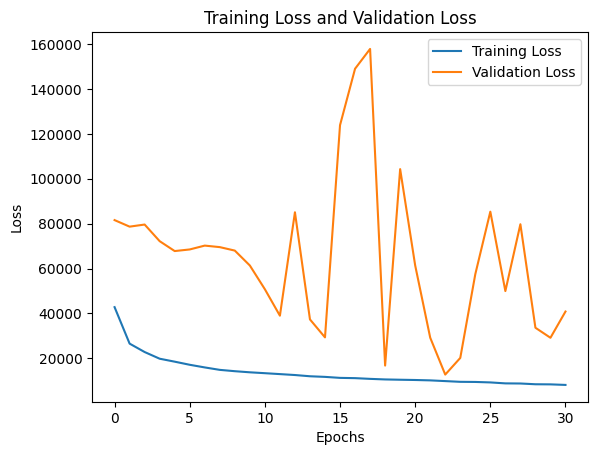

In [43]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.ylim([0,0.01])
plt.legend()
plt.show()

1/1 [==============================] - 0s 25ms/step


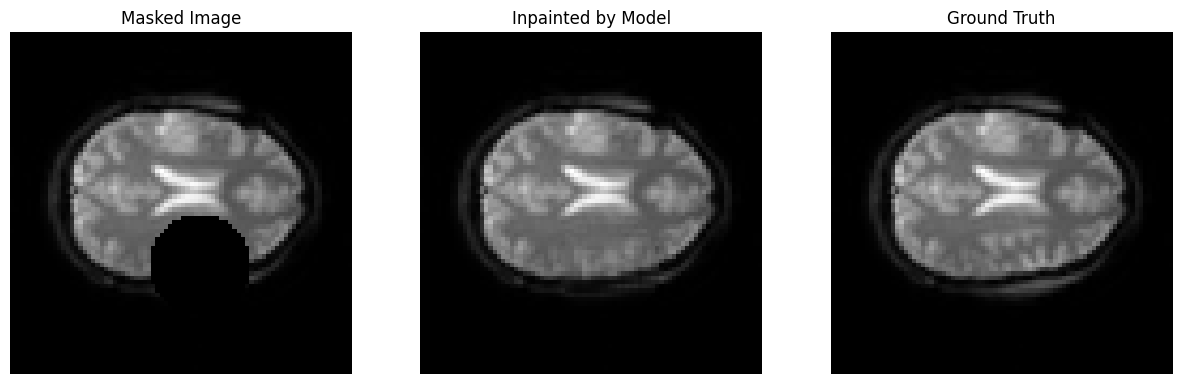

1/1 [==============================] - 0s 32ms/step


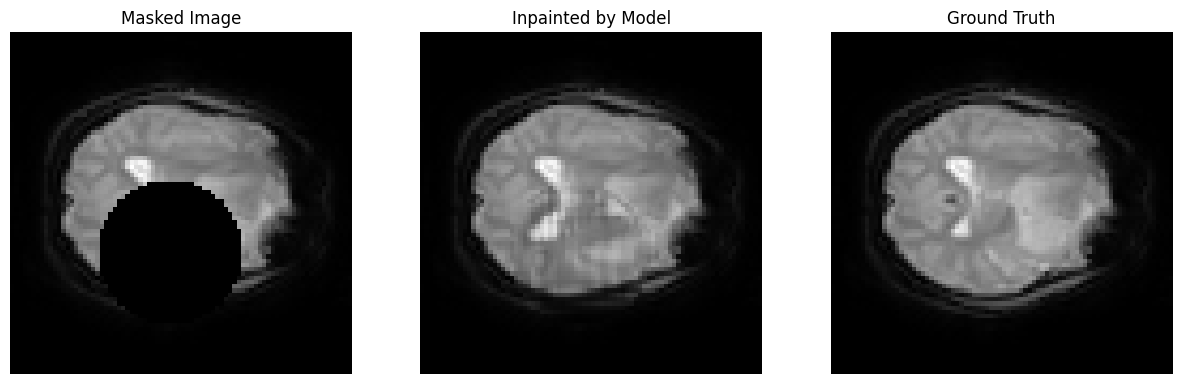

1/1 [==============================] - 0s 39ms/step


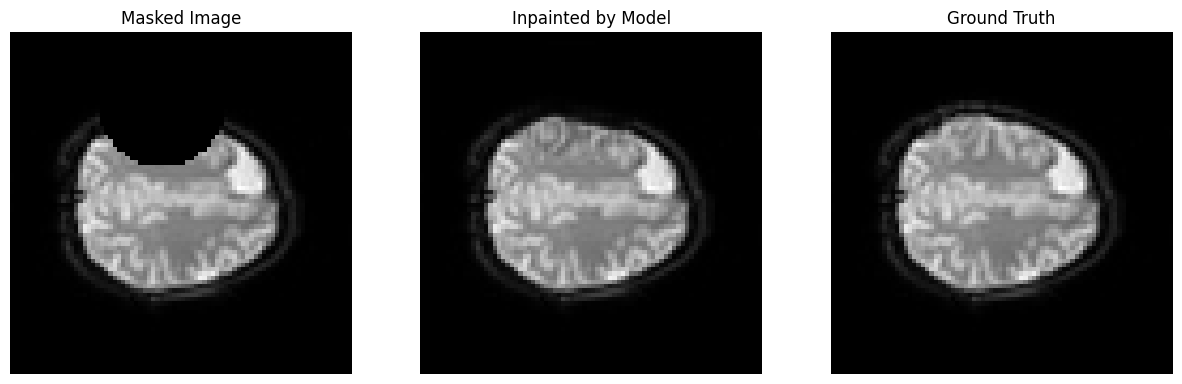

1/1 [==============================] - 0s 23ms/step


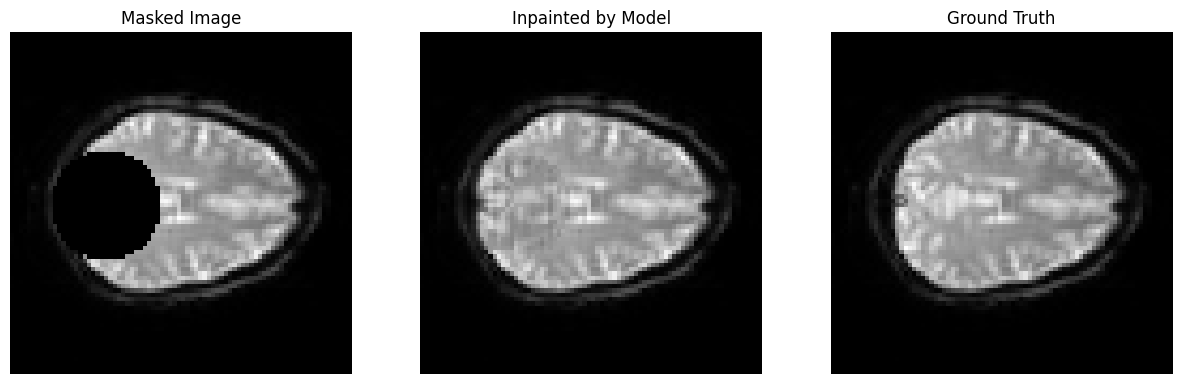

1/1 [==============================] - 0s 34ms/step


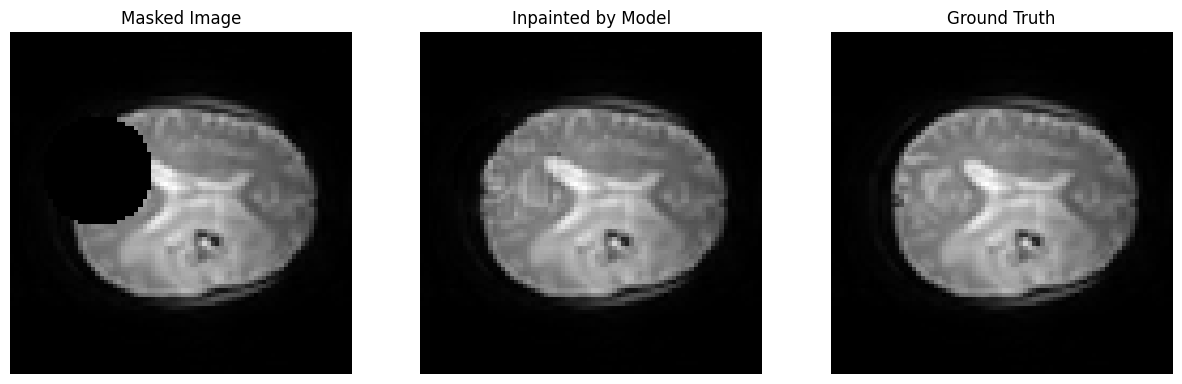

1/1 [==============================] - 0s 22ms/step


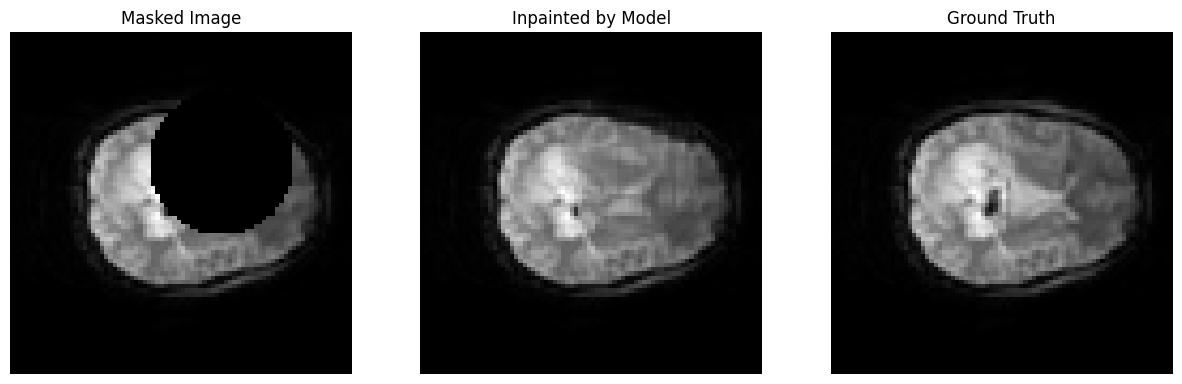

1/1 [==============================] - 0s 22ms/step


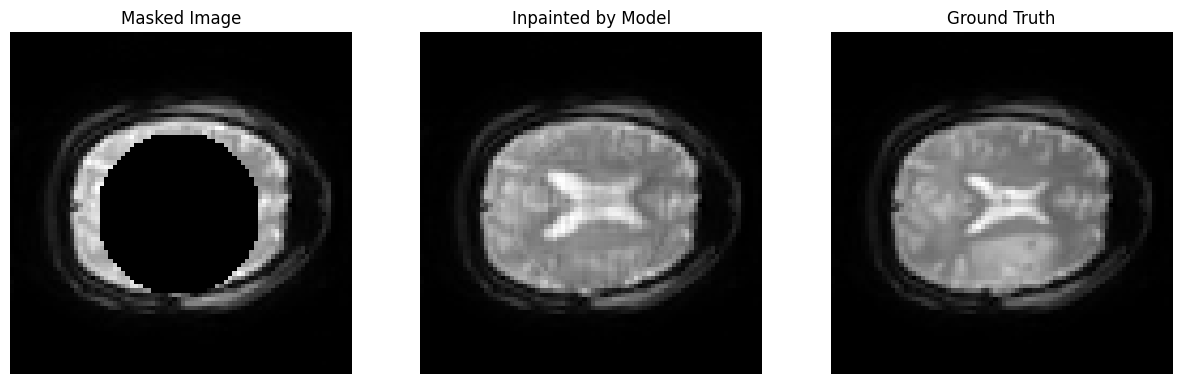

1/1 [==============================] - 0s 22ms/step


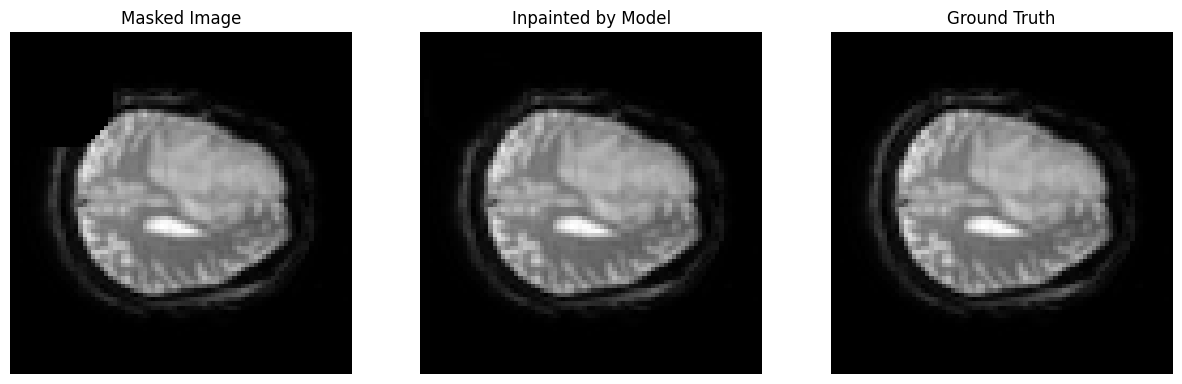

1/1 [==============================] - 0s 24ms/step


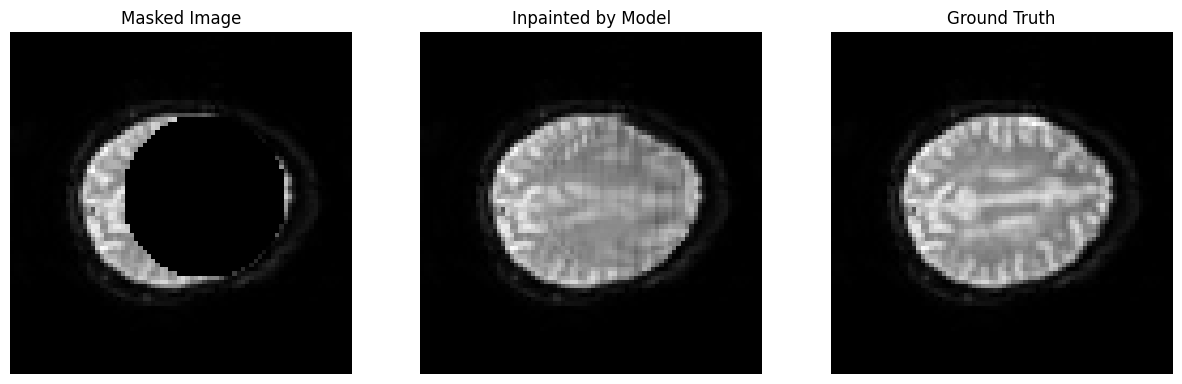

1/1 [==============================] - 0s 20ms/step


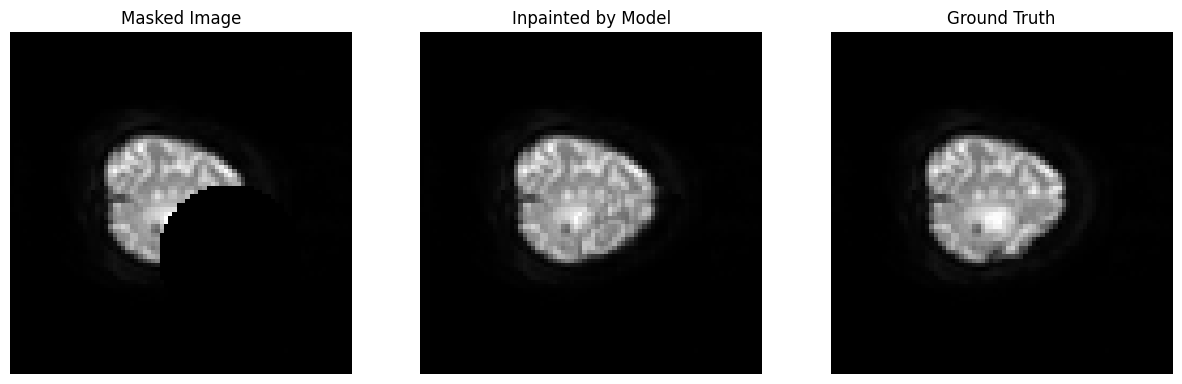

In [65]:
import matplotlib.pyplot as plt

np.random.seed(24)
num_images_to_show = 10

for i in range(num_images_to_show):
    img_index = np.random.randint(len(X_test))  # Use the length of your dataset

    masked_image = X_test[img_index]
    original_image = y_test[img_index]
    mask = masks_test[img_index]
    prediction = model3.predict([masked_image[np.newaxis, ...], original_image[np.newaxis, ...], mask[np.newaxis, ...]])[0]

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(masked_image.squeeze(), cmap='gray')
    plt.title('Masked Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(prediction.squeeze(), cmap='gray')
    plt.title('Inpainted by Model')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(original_image.squeeze(), cmap='gray')
    plt.title('Ground Truth')
    plt.axis('off')

    plt.show()

## Method 4 (mse + perceptual loss)

In [45]:
# from keras.optimizers import Adam
# from keras.callbacks import EarlyStopping
# import tensorflow as tf

# def ssim_loss(y_true, y_pred):
#     return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))  #set 1.0 here because the range of images is [0,1]

# model1 = create_model()
# optimizer = Adam(learning_rate=0.005)
# model1.compile(optimizer=optimizer, loss='mse')


# early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# history = model1.fit([X_train, y_train, masks_train], y_train, epochs=50, batch_size=128, validation_split=0.2, callbacks=[early_stop])


# model1.evaluate([X_test, y_test,masks_test], y_test)


In [46]:
# import matplotlib.pyplot as plt

# plt.figure()
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Training Loss and Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# #plt.ylim([0,0.01])
# plt.legend()
# plt.show()

In [47]:
# import matplotlib.pyplot as plt

# np.random.seed(1)
# num_images_to_show = 10

# for i in range(num_images_to_show):
#     img_index = np.random.randint(len(X_test))  # Use the length of your dataset

#     masked_image = X_test[img_index]
#     original_image = y_test[img_index]
#     mask = masks_test[img_index]
#     prediction = model1.predict([masked_image[np.newaxis, ...], original_image[np.newaxis, ...], mask[np.newaxis, ...]])[0]

#     plt.figure(figsize=(15, 5))

#     plt.subplot(1, 3, 1)
#     plt.imshow(masked_image.squeeze(), cmap='gray')
#     plt.title('Masked Image')
#     plt.axis('off')

#     plt.subplot(1, 3, 2)
#     plt.imshow(prediction.squeeze(), cmap='gray')
#     plt.title('Inpainted by Model')
#     plt.axis('off')

#     plt.subplot(1, 3, 3)
#     plt.imshow(original_image.squeeze(), cmap='gray')
#     plt.title('Ground Truth')
#     plt.axis('off')

#     plt.show()

In [48]:
X_train_1 = model1.predict([X_train, y_train, masks_train])
X_test_1 = model1.predict([X_test, y_test, masks_test])

54/54 [==============================] - 1s 20ms/step


In [49]:
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import tensorflow as tf
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras import backend as K
from keras.layers import Lambda

# Create VGG16 model
vgg = VGG16(include_top=False, weights='imagenet')
loss_model = Model(inputs=vgg.input, outputs=vgg.get_layer('block3_conv3').output)
loss_model.trainable = False

# Function to convert grayscale to RGB
def to_rgb(x):
    return K.concatenate([x, x, x], axis=-1)

def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))  #set 1.0 here because the range of images is [0,1]

def perceptual_loss(y_true, y_pred):
    # Convert images to RGB
    y_true_rgb = to_rgb(y_true)
    y_pred_rgb = to_rgb(y_pred)
    # Scale to [0, 255] for VGG16
    y_true_rgb_scaled = y_true_rgb * 255.0
    y_pred_rgb_scaled = y_pred_rgb * 255.0
    return K.mean(K.square(loss_model(y_true_rgb_scaled) - loss_model(y_pred_rgb_scaled)))

model1_1 = create_model()
optimizer = Adam(learning_rate=0.005)
model1_1.compile(optimizer=optimizer, loss=perceptual_loss)


early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model1_1.fit([X_train_1, y_train, masks_train], y_train, epochs=50, batch_size=128, validation_split=0.2, callbacks=[early_stop])


model1_1.evaluate([X_test_1, y_test,masks_test], y_test)



Epoch 1/50
43/43 [==============================] - 16s 313ms/step - loss: 21877.6230 - val_loss: 195937.0469
Epoch 2/50
43/43 [==============================] - 13s 293ms/step - loss: 14203.6025 - val_loss: 189678.7969
Epoch 3/50
43/43 [==============================] - 13s 295ms/step - loss: 13148.4287 - val_loss: 50357.4258
Epoch 4/50
43/43 [==============================] - 13s 295ms/step - loss: 12489.3623 - val_loss: 45958.1641
Epoch 5/50
43/43 [==============================] - 13s 294ms/step - loss: 11378.4609 - val_loss: 39788.4414
Epoch 6/50
43/43 [==============================] - 13s 294ms/step - loss: 10848.7197 - val_loss: 36843.4023
Epoch 7/50
43/43 [==============================] - 13s 294ms/step - loss: 10466.6787 - val_loss: 35019.9688
Epoch 8/50
43/43 [==============================] - 13s 294ms/step - loss: 10019.6699 - val_loss: 34213.9375
Epoch 9/50
43/43 [==============================] - 13s 294ms/step - loss: 9693.3359 - val_loss: 29786.9648
Epoch 10/50
43/43 

10010.98828125

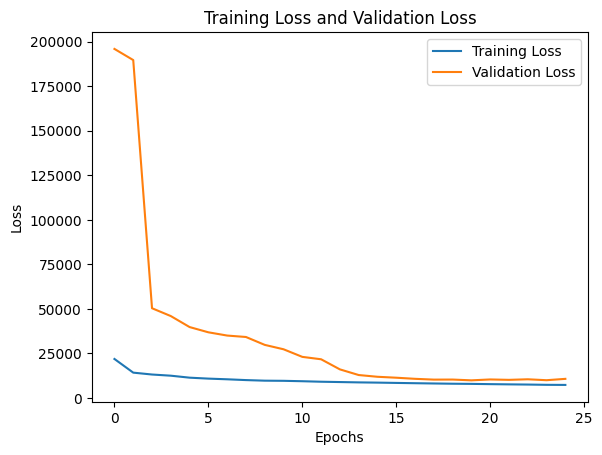

In [50]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.ylim([0,0.01])
plt.legend()
plt.show()

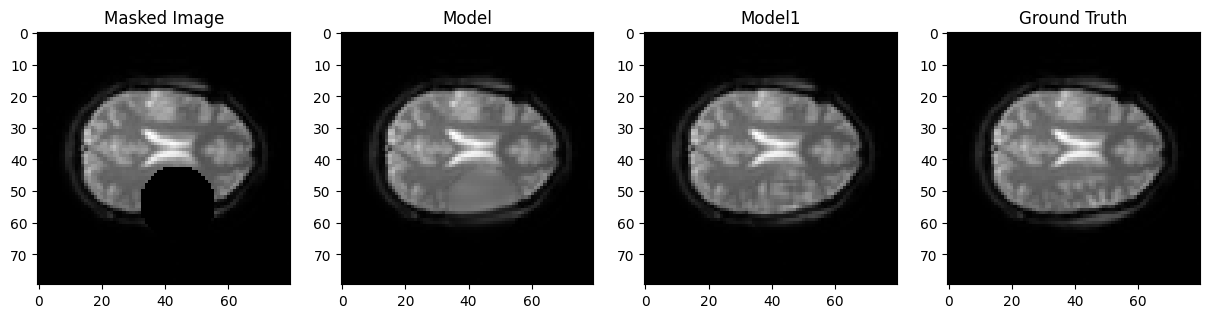

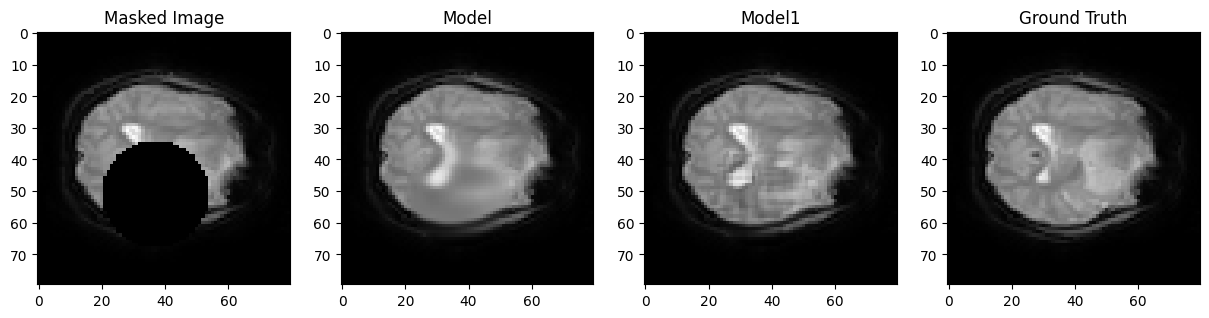

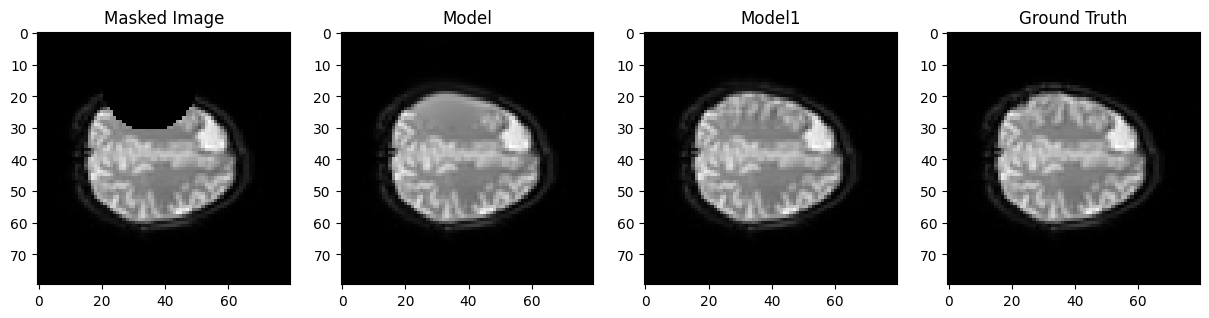

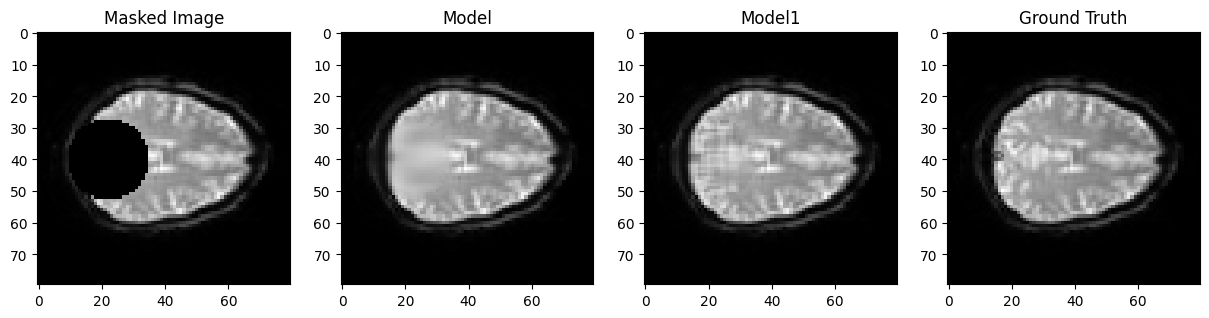

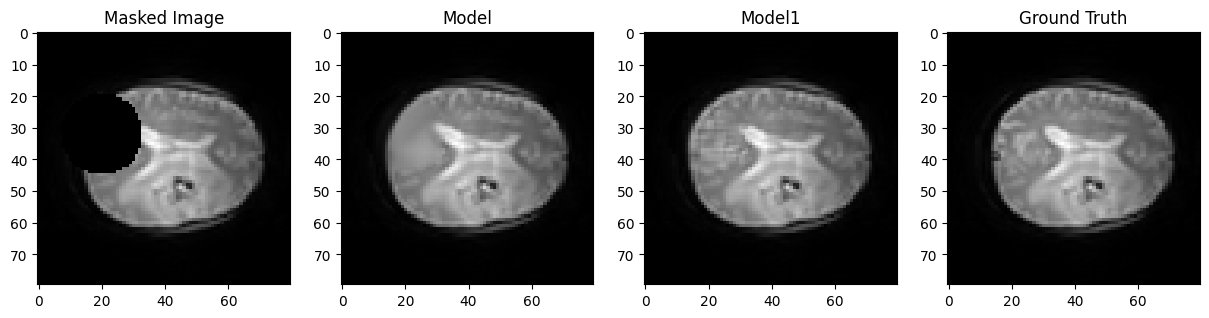

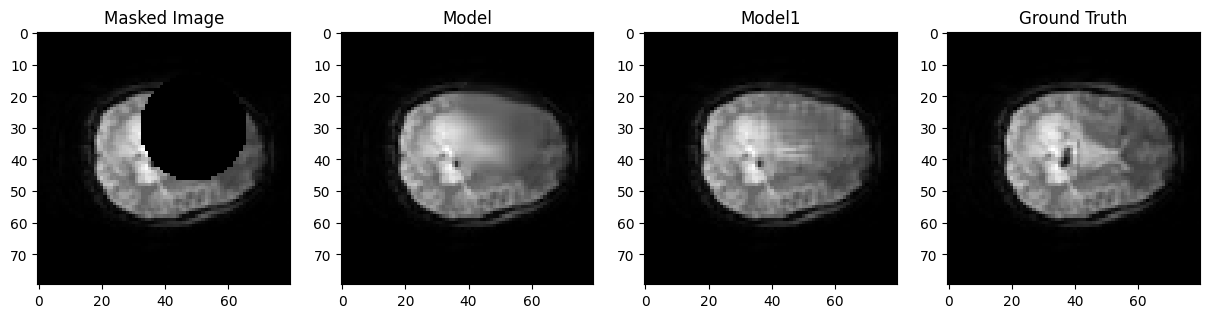

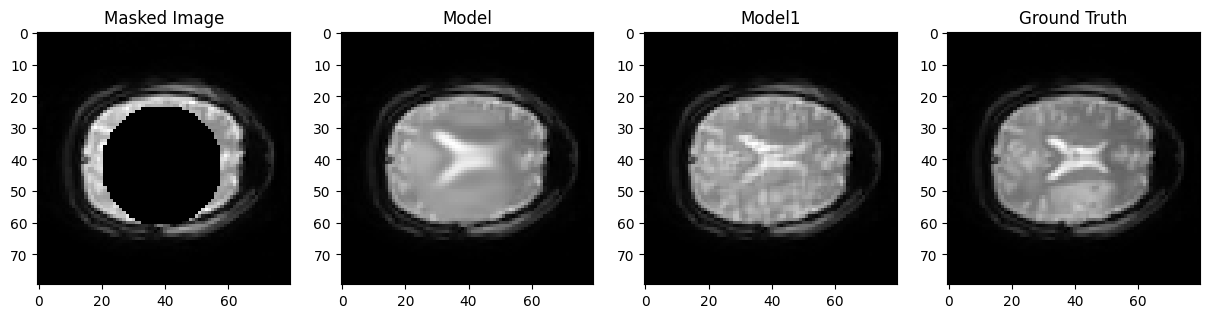

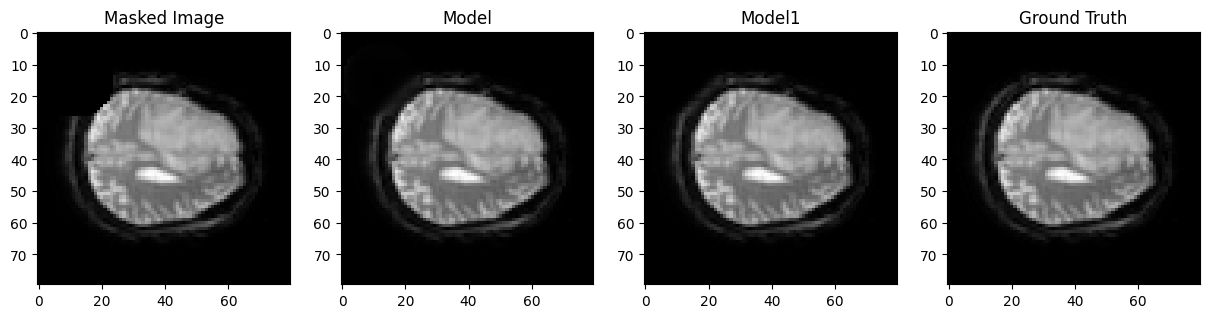

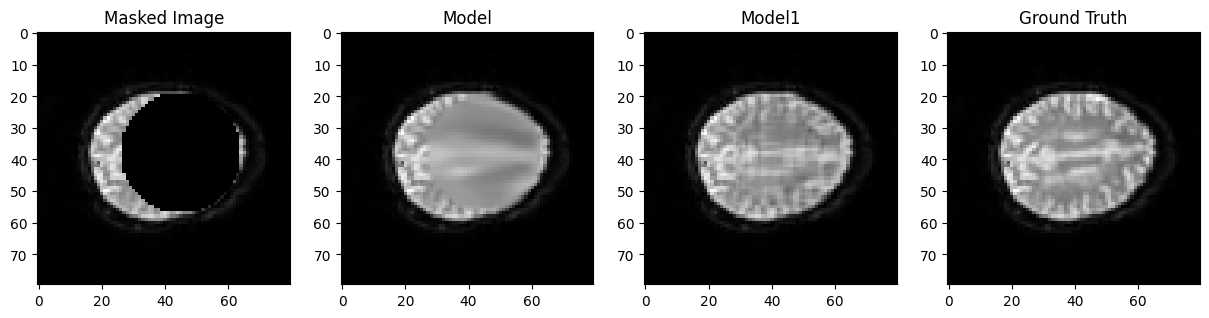

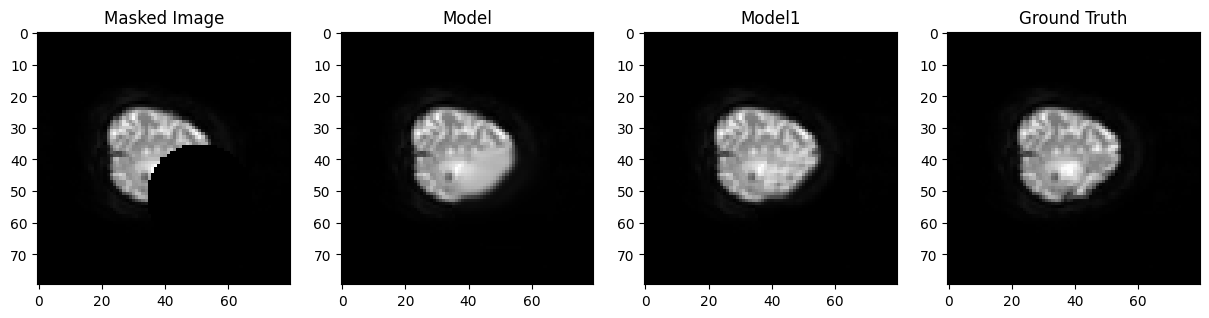

In [64]:
import matplotlib.pyplot as plt

np.random.seed(24)
num_images_to_show = 10

for i in range(num_images_to_show):
    img_index = np.random.randint(len(X_test))  # Use the length of your dataset

    masked_image = X_test[img_index]
    original_image = y_test[img_index]
    mask = masks_test[img_index]
    prediction_1 = model1.predict([masked_image[np.newaxis, ...], original_image[np.newaxis, ...], mask[np.newaxis, ...]], verbose=0)[0]
    prediction_2 = model1_1.predict([prediction_1[np.newaxis, ...], original_image[np.newaxis, ...], mask[np.newaxis, ...]], verbose=0)[0]


    plt.figure(figsize=(15, 5))

    plt.subplot(1, 4, 1)
    plt.imshow(masked_image.squeeze(), cmap='gray')
    plt.title('Masked Image')

    plt.subplot(1, 4, 2)
    plt.imshow(prediction_1.squeeze(), cmap='gray')
    plt.title('Model')

    plt.subplot(1, 4, 3)
    plt.imshow(prediction_2.squeeze(), cmap='gray')
    plt.title('Model1')

    plt.subplot(1, 4, 4)
    plt.imshow(original_image.squeeze(), cmap='gray')
    plt.title('Ground Truth')

    plt.show()

## Method 5(mse + ssim loss)

In [52]:
X_train_1 = model1.predict([X_train, y_train, masks_train])
X_test_1 = model1.predict([X_test, y_test, masks_test])

54/54 [==============================] - 1s 20ms/step


In [59]:
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import tensorflow as tf

def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))  #set 1.0 here because the range of images is [0,1]

model1_2 = create_model()
optimizer = Adam(learning_rate=0.001)
model1_2.compile(optimizer=optimizer, loss=ssim_loss)


early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model1_2.fit([X_train_1, y_train, masks_train], y_train, epochs=50, batch_size=128, validation_split=0.2, callbacks=[early_stop])


model1_2.evaluate([X_test_1, y_test,masks_test], y_test)


Epoch 1/50
43/43 [==============================] - 14s 269ms/step - loss: 0.0541 - val_loss: 0.1454
Epoch 2/50
43/43 [==============================] - 11s 250ms/step - loss: 0.0413 - val_loss: 0.1443
Epoch 3/50
43/43 [==============================] - 11s 250ms/step - loss: 0.0405 - val_loss: 0.1429
Epoch 4/50
43/43 [==============================] - 11s 250ms/step - loss: 0.0401 - val_loss: 0.1398
Epoch 5/50
43/43 [==============================] - 11s 251ms/step - loss: 0.0398 - val_loss: 0.1397
Epoch 6/50
43/43 [==============================] - 11s 251ms/step - loss: 0.0392 - val_loss: 0.1318
Epoch 7/50
43/43 [==============================] - 11s 251ms/step - loss: 0.0389 - val_loss: 0.1296
Epoch 8/50
43/43 [==============================] - 11s 251ms/step - loss: 0.0382 - val_loss: 0.1229
Epoch 9/50
43/43 [==============================] - 11s 251ms/step - loss: 0.0378 - val_loss: 0.1192
Epoch 10/50
43/43 [==============================] - 11s 251ms/step - loss: 0.0372 - val_lo

0.04809413105249405

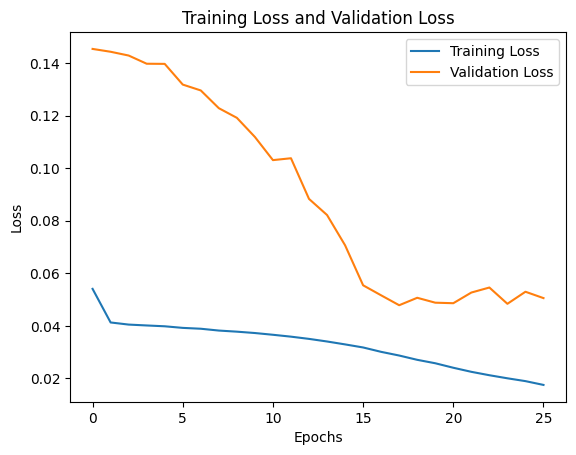

In [60]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.ylim([0,0.01])
plt.legend()
plt.show()

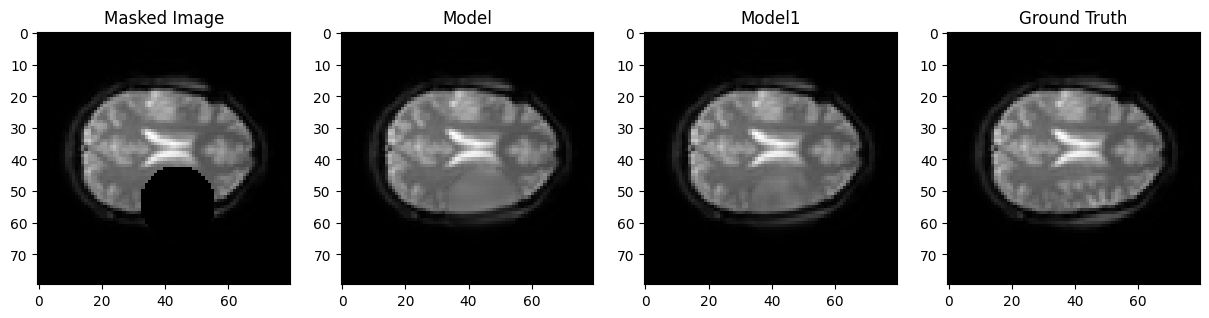

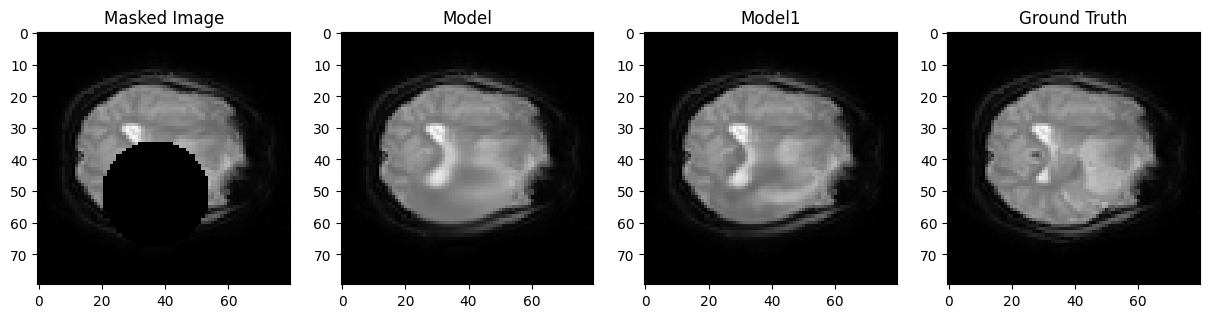

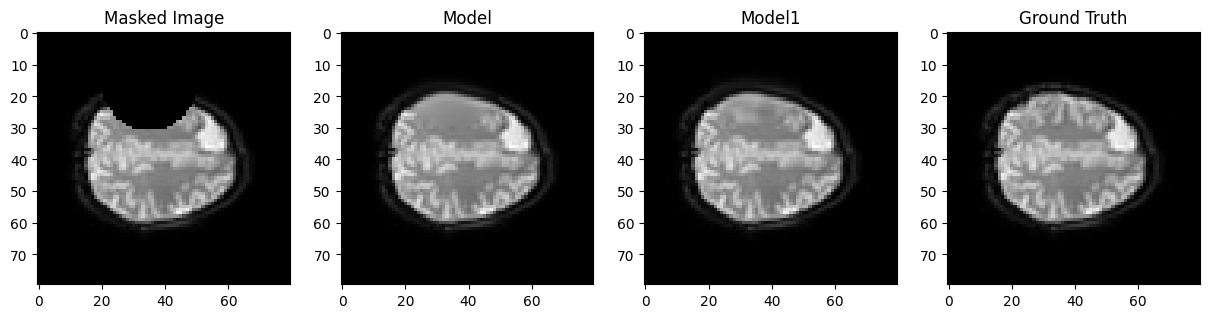

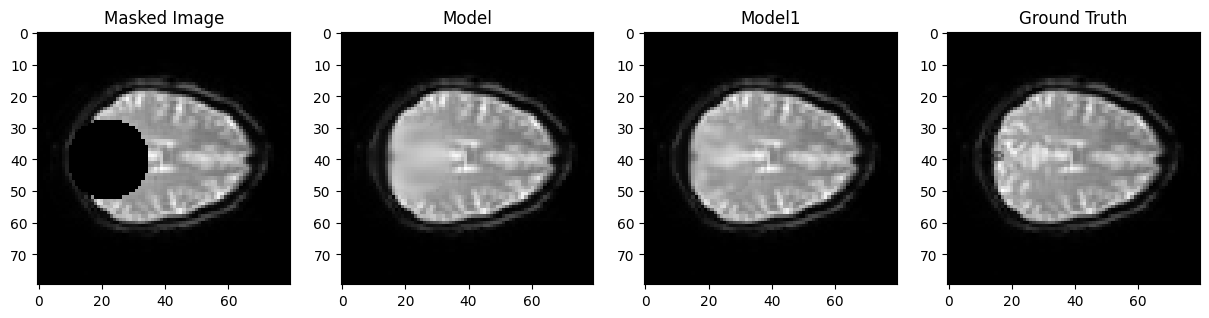

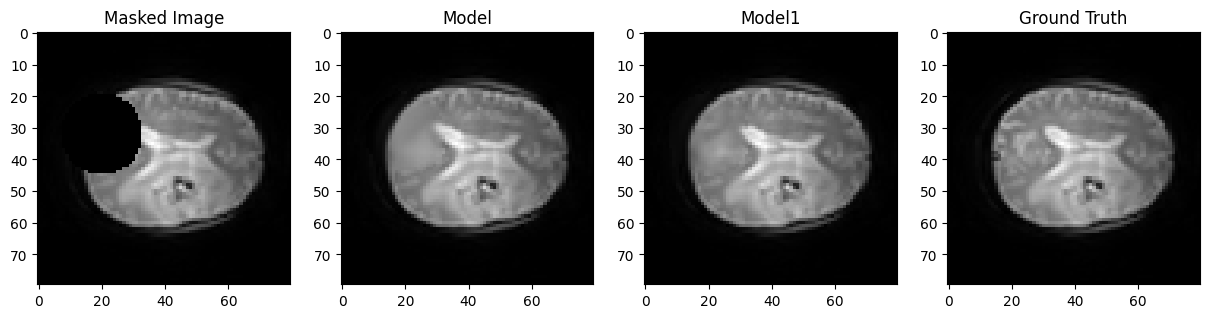

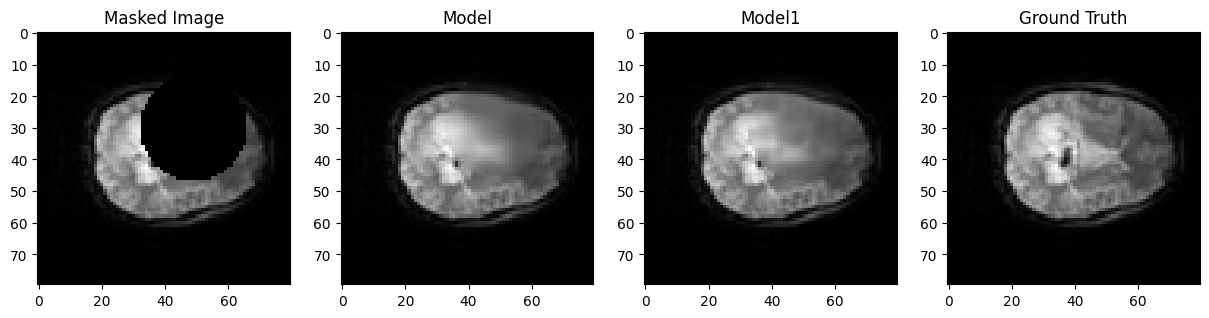

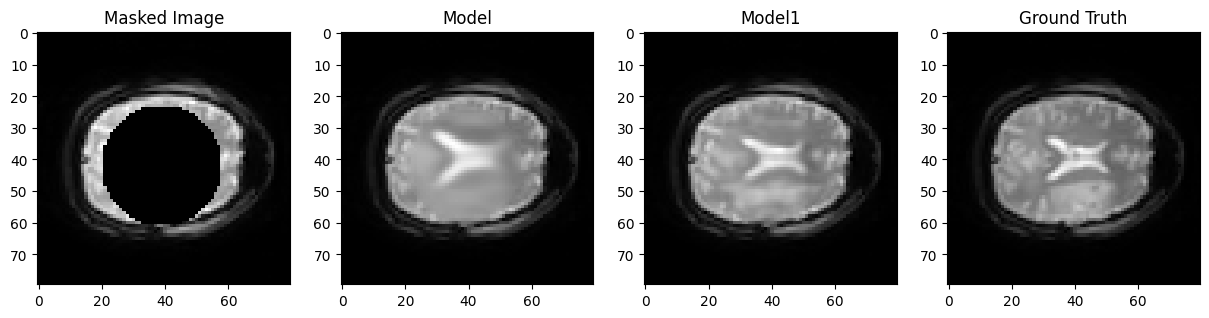

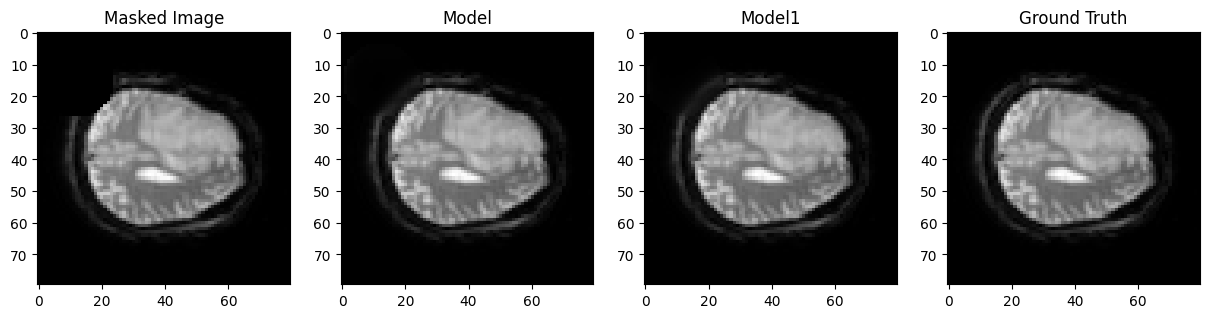

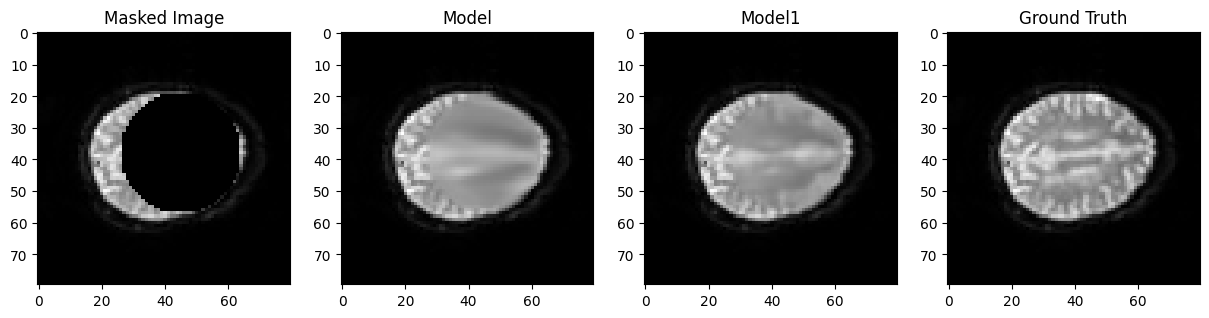

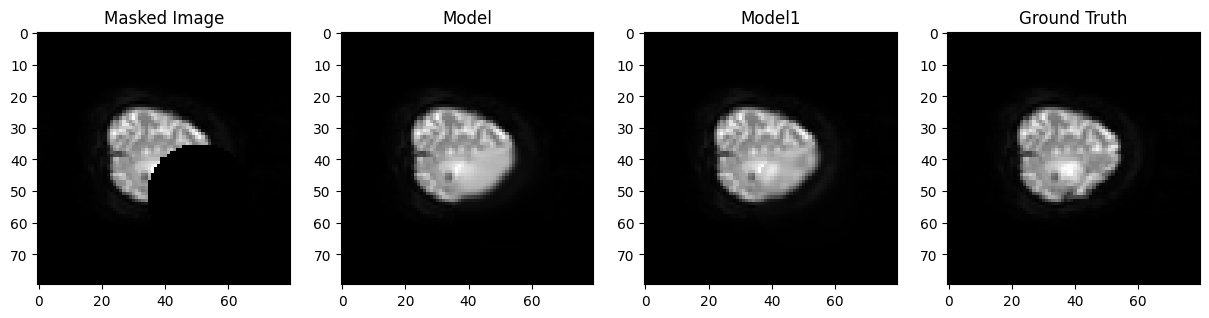

In [63]:
import matplotlib.pyplot as plt

np.random.seed(24)
num_images_to_show = 10

for i in range(num_images_to_show):
    img_index = np.random.randint(len(X_test))  # Use the length of your dataset

    masked_image = X_test[img_index]
    original_image = y_test[img_index]
    mask = masks_test[img_index]
    prediction_1 = model1.predict([masked_image[np.newaxis, ...], original_image[np.newaxis, ...], mask[np.newaxis, ...]], verbose=0)[0]
    prediction_2 = model1_2.predict([prediction_1[np.newaxis, ...], original_image[np.newaxis, ...], mask[np.newaxis, ...]], verbose=0)[0]


    plt.figure(figsize=(15, 5))

    plt.subplot(1, 4, 1)
    plt.imshow(masked_image.squeeze(), cmap='gray')
    plt.title('Masked Image')

    plt.subplot(1, 4, 2)
    plt.imshow(prediction_1.squeeze(), cmap='gray')
    plt.title('Model')

    plt.subplot(1, 4, 3)
    plt.imshow(prediction_2.squeeze(), cmap='gray')
    plt.title('Model1')

    plt.subplot(1, 4, 4)
    plt.imshow(original_image.squeeze(), cmap='gray')
    plt.title('Ground Truth')

    plt.show()

## Overall results

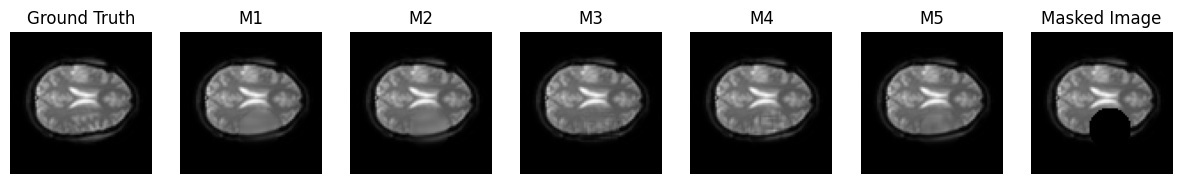

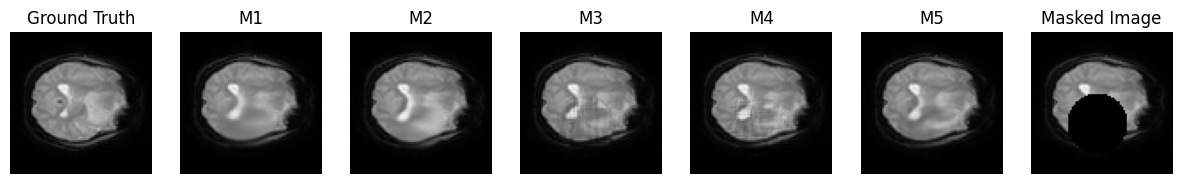

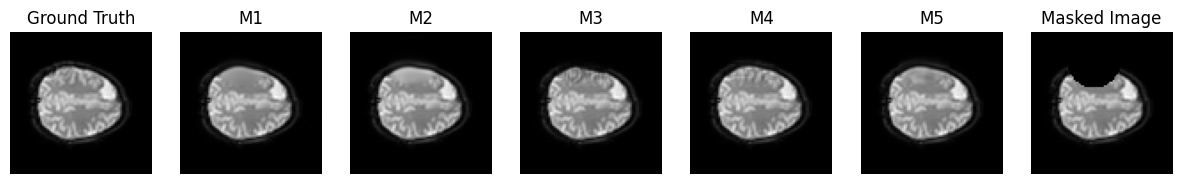

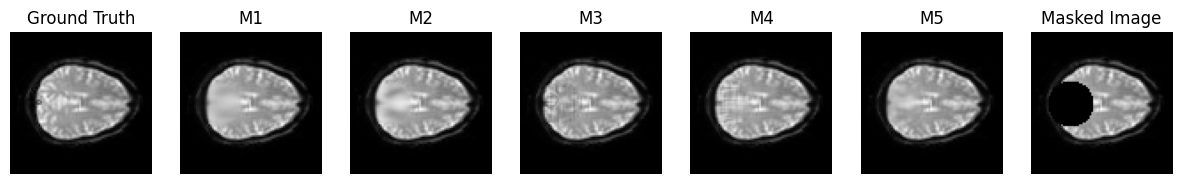

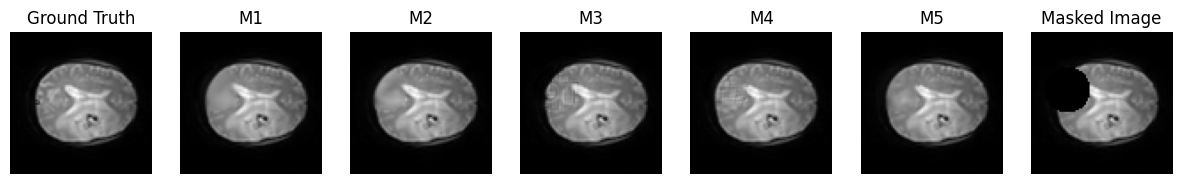

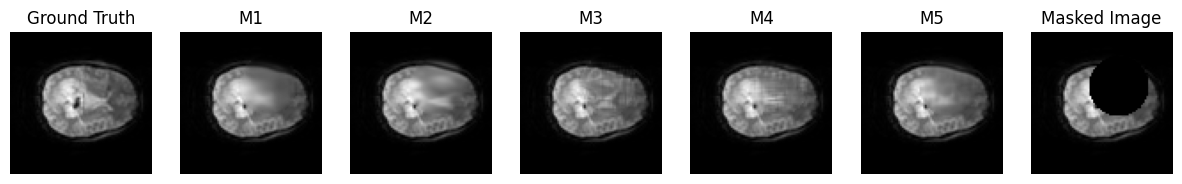

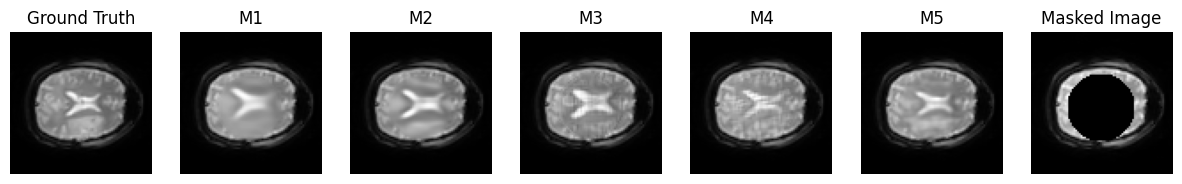

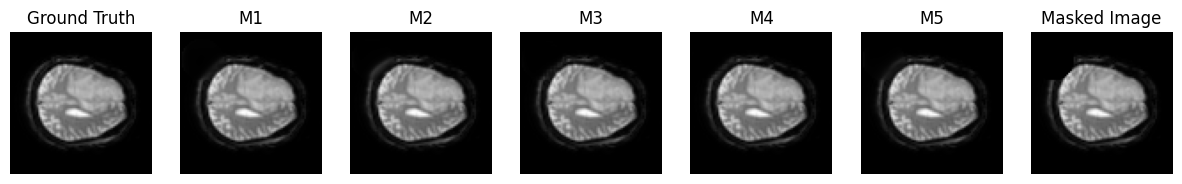

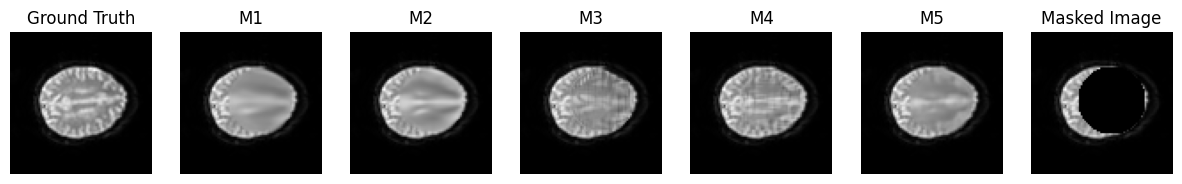

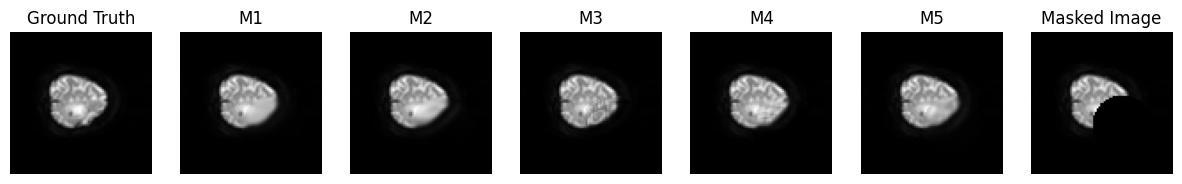

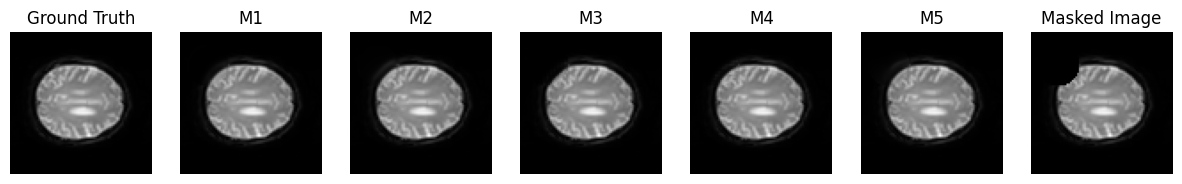

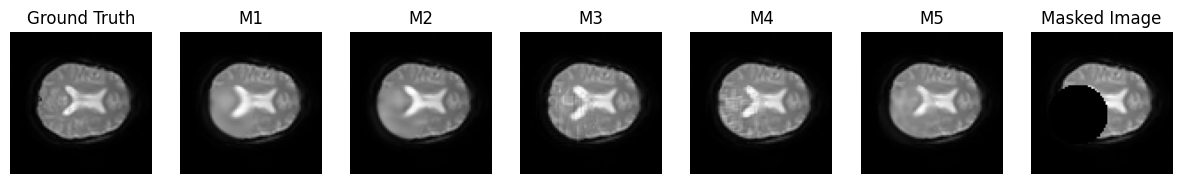

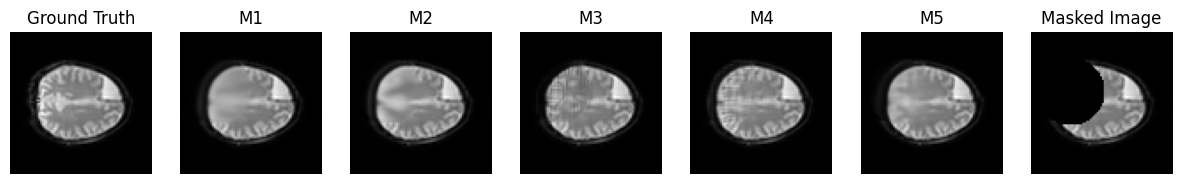

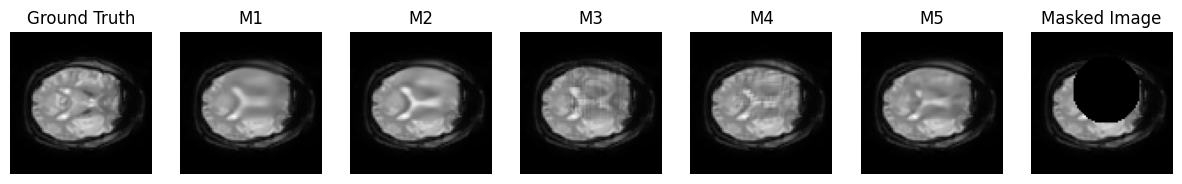

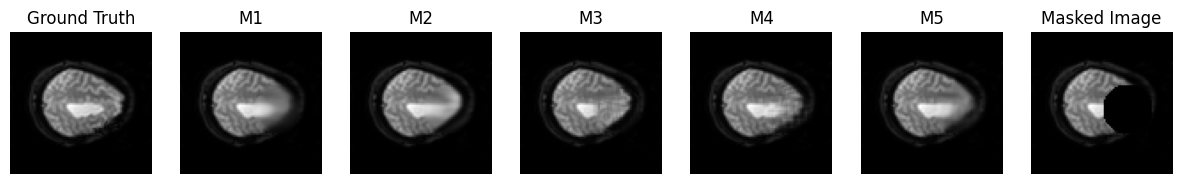

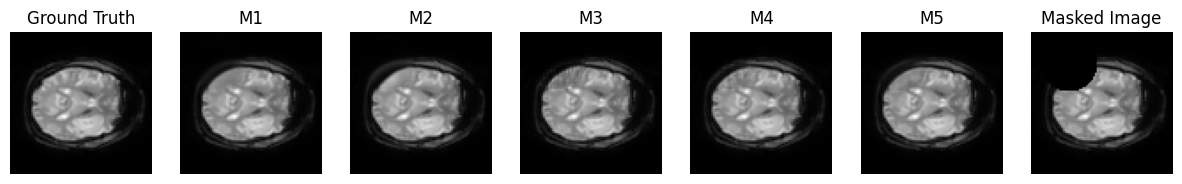

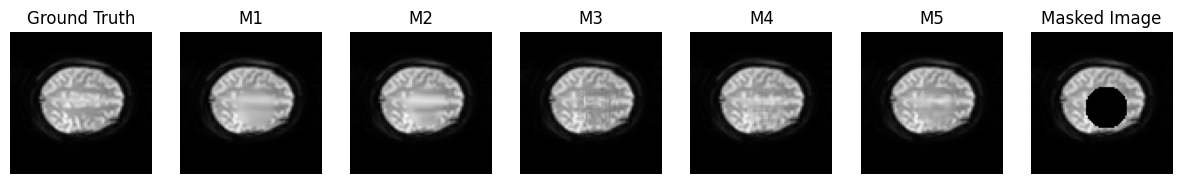

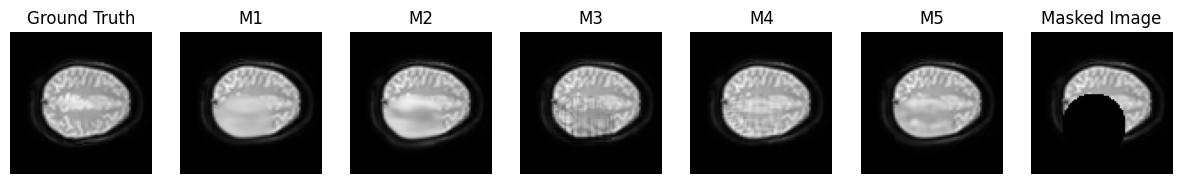

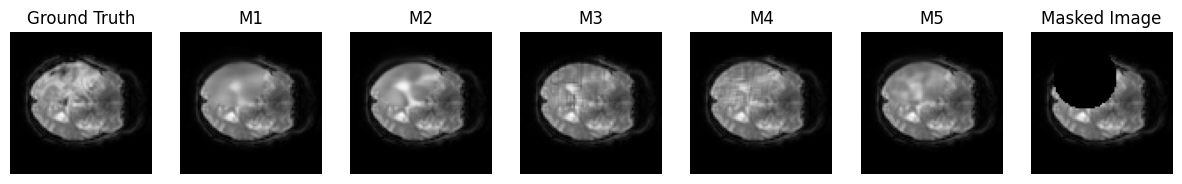

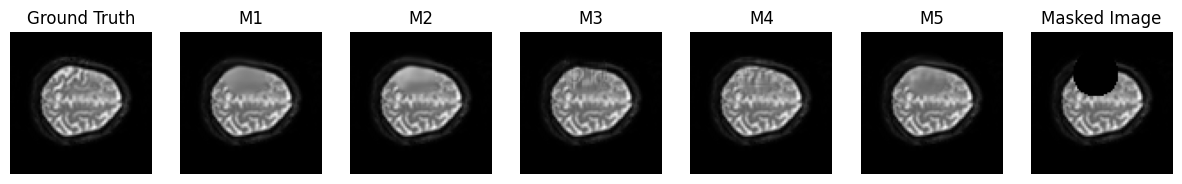

In [62]:
import matplotlib.pyplot as plt

np.random.seed(24)
num_images_to_show = 20

for i in range(num_images_to_show):
    img_index = np.random.randint(len(X_test))
    masked_image = X_test[img_index]
    original_image = y_test[img_index]
    mask = masks_test[img_index]

    pred_1 = model1.predict([masked_image[np.newaxis, ...], original_image[np.newaxis, ...], mask[np.newaxis, ...]], verbose=0)[0]
    pred_2 = model2.predict([masked_image[np.newaxis, ...], original_image[np.newaxis, ...], mask[np.newaxis, ...]], verbose=0)[0]
    pred_3 = model3.predict([masked_image[np.newaxis, ...], original_image[np.newaxis, ...], mask[np.newaxis, ...]], verbose=0)[0]
    pred_1_1 = model1_1.predict([pred_1[np.newaxis, ...], original_image[np.newaxis, ...], mask[np.newaxis, ...]], verbose=0)[0]
    pred_1_2 = model1_2.predict([pred_1[np.newaxis, ...], original_image[np.newaxis, ...], mask[np.newaxis, ...]], verbose=0)[0]

    plt.figure(figsize=(15, 10))

    plt.subplot(1, 7, 1)
    plt.imshow(original_image.squeeze(), cmap='gray')
    plt.title('Ground Truth')
    plt.axis('off')

    plt.subplot(1, 7, 2)
    plt.imshow(pred_1.squeeze(), cmap='gray')
    plt.title('M1')
    plt.axis('off')

    plt.subplot(1, 7, 3)
    plt.imshow(pred_2.squeeze(), cmap='gray')
    plt.title('M2')
    plt.axis('off')

    plt.subplot(1, 7, 4)
    plt.imshow(pred_3.squeeze(), cmap='gray')
    plt.title('M3')
    plt.axis('off')

    plt.subplot(1, 7, 5)
    plt.imshow(pred_1_1.squeeze(), cmap='gray')
    plt.title('M4')
    plt.axis('off')

    plt.subplot(1, 7, 6)
    plt.imshow(pred_1_2.squeeze(), cmap='gray')
    plt.title('M5')
    plt.axis('off')


    plt.subplot(1, 7, 7)
    plt.imshow(masked_image.squeeze(), cmap='gray')
    plt.title('Masked Image')
    plt.axis('off')

    plt.show()